# atmaCup#9 - スマートショッピングカート

## Import Libraries

In [2]:
# 분석용 라이브러리

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [3]:
# 시각화 라이브러리

import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("fivethirtyeight")

font_name = 'NanumBarunGothic'
plt.rc('font', family=font_name)

In [4]:
# 유용한 라이브러리

import os
from time import time
from tqdm import tqdm
import gc

import warnings
warnings.filterwarnings("ignore")

## Util Functions

In [5]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def savefig(fig, to):
    to = os.path.join(OUTPUT_DIR, to + '.png')
    print('save to {}'.format(to))
    fig.tight_layout()
    fig.savefig(to, dpi=120)

## Load Data

In [8]:
INPUT_DIR = 'input/'
OUTPUT_DIR = 'output/'

# INPUT_DIR = '/content/drive/MyDrive/Competition/atmaCup9/input/'
# OUTPUT_DIR = '/content/drive/MyDrive/Competition/atmaCup9/output/'

In [9]:
%%time

# cartlog
log_df = pd.read_csv(os.path.join(INPUT_DIR, 'cartlog.csv'), 
                     dtype={ 'value_1': str }, 
                     parse_dates=['date'])

# meta data
meta_df = pd.read_csv(os.path.join(INPUT_DIR, 'meta.csv'), parse_dates=['date'])

# product master
product_master_df = pd.read_csv(os.path.join(INPUT_DIR, 'product_master.csv'), dtype={'JAN':str})

# User Master
user_df = pd.read_csv(os.path.join(INPUT_DIR, 'user_master.csv'))

# test data
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

# display_action_id.csv
display_action_id_df = pd.read_csv(os.path.join(INPUT_DIR, "display_action_id.csv"))

display_action = display_action_id_df[["display_name", "action_name"]].apply("_".join, 1)
display_action2name = dict(zip(display_action_id_df['display_action_id'], display_action))

Wall time: 35.9 s


## Preprocess

In [10]:
TARGET_CATEGORIES = [
    # お酒に関するもの
    'ビール系__RTD', 'ビール系__ビール系', 'ビール系__ノンアルコール',

    # お菓子に関するもの
    'スナック・キャンディー__スナック', 
    'チョコ・ビスクラ__チョコレート', 
    'スナック・キャンディー__ガム', 
    'スナック・キャンディー__シリアル',
    'アイスクリーム__ノベルティー', 
    '和菓子__米菓',

    # 飲料に関するもの
    '水・炭酸水__大型PET（炭酸水）',
    '水・炭酸水__小型PET（炭酸水）',
    '缶飲料__コーヒー（缶）',
    '小型PET__コーヒー（小型PET）',
    '大型PET__無糖茶（大型PET）',

    # 麺類
    '麺類__カップ麺',
]

# 카레고리 이름 <-> 카테고리 id
cat2id = dict(zip(product_master_df['category_name'], product_master_df['category_id']))
id2cat = dict(zip(product_master_df['category_id'], product_master_df['category_name']))

TARGET_IDS = pd.Series(TARGET_CATEGORIES).map(cat2id).values.tolist()

for id_, name in zip(TARGET_IDS, TARGET_CATEGORIES):
    print(id_, name)

171 ビール系__RTD
173 ビール系__ビール系
172 ビール系__ノンアルコール
114 スナック・キャンディー__スナック
134 チョコ・ビスクラ__チョコレート
110 スナック・キャンディー__ガム
113 スナック・キャンディー__シリアル
38 アイスクリーム__ノベルティー
376 和菓子__米菓
537 水・炭酸水__大型PET（炭酸水）
539 水・炭酸水__小型PET（炭酸水）
629 缶飲料__コーヒー（缶）
467 小型PET__コーヒー（小型PET）
435 大型PET__無糖茶（大型PET）
768 麺類__カップ麺


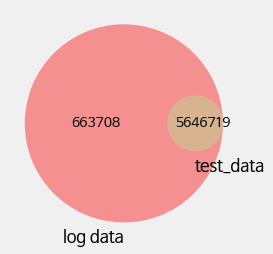

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))

left_set = set(log_df['session_id'].unique())
right_set = set(test_df['session_id'].unique())

venn2(subsets=(left_set, right_set),
      set_labels=('log data', 'test_data'), 
      ax=ax)

plt.show()

In [12]:
test_sessions = test_df['session_id'].unique()

# log_df의 session_id 중 test_df에 포함된 session_id를 제거한다
only_in_log_df = log_df[~log_df['session_id'].isin(test_sessions)].reset_index(drop=True)

test_public_df = log_df[log_df['session_id'].isin(test_sessions)].reset_index(drop=True)

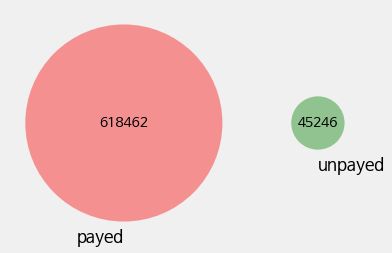

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

payed_sessions = only_in_log_df[only_in_log_df['is_payment']==1]['session_id'].unique()

left_set = set(payed_sessions)
right_set = set(only_in_log_df[~only_in_log_df['session_id'].isin(payed_sessions)]['session_id'].unique())

venn2(subsets=(left_set, right_set),
      set_labels=('payed', 'unpayed'), 
      ax=ax)

plt.show()

In [14]:
def filter_payment_logs(log_df:pd.DataFrame) -> pd.DataFrame:
    """
    구매 기록이 남은 session_id만을 남긴다
    """
    payed_sessions = log_df[log_df['is_payment'] == 1]['session_id'].unique()
    idx = log_df['session_id'].isin(payed_sessions)
    output_df = log_df[idx].reset_index(drop=True)
    return output_df

In [15]:
%%time

# 구매 기록이 남은 세션만 남긴다
payed_session_df = filter_payment_logs(only_in_log_df)

Wall time: 3.1 s


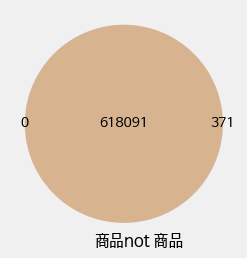

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))

left_set = set(payed_session_df[payed_session_df['kind_1'] == '商品']['session_id'].unique())
right_set = set(payed_session_df[payed_session_df['kind_1'] != '商品']['session_id'].unique())

venn2(subsets=(left_set, right_set),
      set_labels=('商品', 'not 商品'), 
      ax=ax)

plt.show()

In [17]:
is_item_record = payed_session_df['kind_1'] == '商品'

train_sessions = payed_session_df[is_item_record].groupby('session_id', as_index=False)[['spend_time']].max()
train_sessions.rename(columns={'spend_time':'max_spend_time'}, inplace=True)

In [18]:
time_elapsed_count = meta_df['time_elapsed'].value_counts(normalize=True)

train_time_elapsed = np.random.choice(time_elapsed_count.index.astype(int), 
                                      p=time_elapsed_count.values, 
                                      size=len(train_sessions))
train_sessions['time_elapsed'] = train_time_elapsed * 60

train_sessions = train_sessions[train_sessions['max_spend_time'] > train_sessions['time_elapsed']]

In [19]:
train_meta_df = pd.merge(train_sessions.drop(columns=['max_spend_time']), 
                         meta_df.drop(columns='time_elapsed'), 
                         on='session_id', 
                         how='left')

test_meta_df = pd.merge(test_df, meta_df, on='session_id', how='left')

In [20]:
train_meta_df = train_meta_df.merge(user_df, on='user_id', how='left')
test_meta_df = test_meta_df.merge(user_df, on='user_id', how='left')

In [21]:
train_meta_df.head()

,session_id,time_elapsed,user_id,date,hour,register_number,age,gender
0,5,0,aevjzCB5vr8sjgM3yfq82C,2019-02-14,5,2002,20.0,1.0
1,7,0,RfxmdvU7hLR5NMhfZyRkLt,2019-02-14,5,2002,50.0,1.0
2,14,0,5x23SyfSjWtkX9xK4sE5vc,2019-02-14,6,2001,50.0,1.0
3,17,0,gRFKs4Sp53DA8BdyM2Wayj,2019-02-14,6,2001,20.0,0.0
4,23,0,WajjJFXbkYp2Ck3aiik45g,2019-02-14,6,2006,40.0,0.0


In [22]:
train_session_df = payed_session_df[payed_session_df['session_id'].isin(train_sessions['session_id'])].reset_index(drop=True)

In [23]:
_df = pd.merge(train_session_df[['session_id', 'spend_time']], 
               train_meta_df, 
               on='session_id', 
               how='left')

show_idx = _df['spend_time'] <= _df['time_elapsed']

# train_data의 비율
np.mean(show_idx)

0.23432613255093243

In [24]:
train_public_df = train_session_df[show_idx].reset_index(drop=True)
train_private_df = train_session_df[~show_idx].reset_index(drop=True)

# test_df와 session_id를 공유하는 레코드와 함께 보존한다
public_log_df = pd.concat([
    train_public_df,
    test_public_df
], axis=0, ignore_index=True)

In [25]:
def plot_intersection(left, right, column, set_labels, ax=None):
    left_set = set(left[column])
    right_set = set(right[column])
    venn2(subsets=(left_set, right_set), set_labels=set_labels, ax=ax)
    return ax

def plot_right_left_intersection(train_df, test_df, columns='__all__'):
    if columns=='__all__':
        columns = set(train_df.columns) & set(test_df.columns)
        
    columns = list(columns)
    nfigs = len(columns)
    ncols = 6
    nrows = - ( - nfigs // ncols)
    fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
    axes = np.ravel(axes)
    for c, ax in zip(columns, axes):
        plot_intersection(train_df, test_df, column=c, set_labels=('Train', 'Test'), ax=ax)
        ax.set_title(c)
    return fig, ax

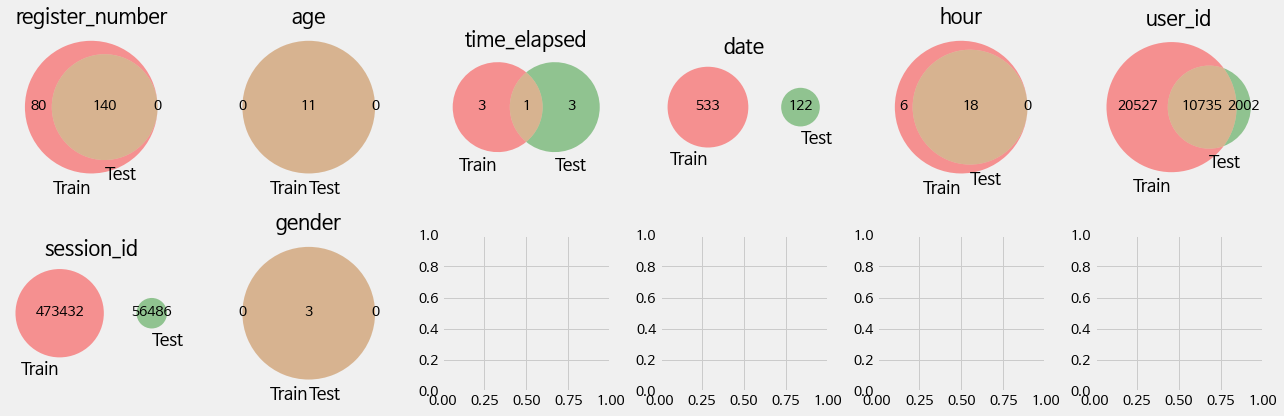

In [26]:
fig, _ = plot_right_left_intersection(train_meta_df, test_meta_df)
fig.tight_layout()

In [27]:
# 세션, 상품별 구입갯구

def create_payment(input_df:pd.DataFrame) -> pd.DataFrame:
    idx = input_df['kind_1'] == '商品'
    output_df = input_df[idx].reset_index(drop=True)
    
    output_df = output_df.groupby(['session_id', 'value_1'])['n_items'].sum().reset_index()
    output_df = output_df.rename(columns={'value_1':'JAN'})
    return output_df

def annot_category(input_df:pd.DataFrame, master_df:pd.DataFrame) -> pd.Series:
    if 'value_1' in input_df.columns:
        input_df = input_df.rename(columns={'value_1':'JAN'})
    output_df = pd.merge(input_df['JAN'], master_df[['JAN', 'category_id']], on='JAN', how='left')
    return output_df['category_id']

def only_payment_session_record(log_df:pd.DataFrame) -> pd.DataFrame:
    payed_sessions = log_df[log_df['is_payment'] == 1]['session_id'].unique()
    idx = log_df['session_id'].isin(payed_sessions)
    output_df = log_df[idx].reset_index(drop=True)
    return output_df

def create_target_from_log(log_df:pd.DataFrame, 
                           product_master_df:pd.DataFrame, 
                           only_payment=True) -> (pd.DataFrame, pd.DataFrame):
    
    if only_payment:
        log_df = only_payment_session_record(log_df)
    pay_df = create_payment(log_df) # 세션, 상품 별 갯수
    pay_df['category_id'] = annot_category(input_df=pay_df, master_df=product_master_df)
    
    idx_null = pay_df['category_id'].isnull()
    pay_df = pay_df[~idx_null].reset_index(drop=True)
    pay_df['category_id'] = pay_df['category_id'].astype(int)
    
    idx = pay_df['category_id'].isin(TARGET_IDS)
    target_df = pd.pivot_table(
        data=pay_df[idx],
        index='session_id',
        columns='category_id',
        values='n_items',
        aggfunc='sum'
    )
    
    sessions = sorted(log_df['session_id'].unique())
    print(len(sessions))
    target_df = target_df.reindex(sessions)
    target_df = target_df.fillna(0).astype(int)
    return (target_df, pay_df)

In [28]:
# 見えたらダメなデータを使ってターゲットの計算を行う。これを学習時のラベルとする！　
train_target_df, _ = create_target_from_log(train_private_df, 
                                            product_master_df, 
                                            only_payment=False)

train_target_df = (train_target_df > 0).astype(int)

473432


In [29]:
assert len(train_target_df) == len(train_meta_df)

train_public_df + test_public_df -> public_log_df

(train_meta_df, train_target_df)

test_meta_df

In [30]:
if ' log_df' in locals():
    del log_df
gc.collect()

34

## Feature Engineering

### AbstractBaseBlock

In [31]:
class AbstractBaseBlock:
    def fit(self, input_df:pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        raise NotImplementedError()

### Session Feature

#### 발생한 시간대 정보

In [32]:
class DateBlock(AbstractBaseBlock):
    def transform(self, input_df:pd.DataFrame):
        date = pd.to_datetime(input_df['date'])
        
        output_df = pd.DataFrame({
            'dayofweek': date.dt.dayofweek,
            'day': date.dt.day,
            'month': date.dt.month,
            'year': date.dt.year
        })
        
        output_df['hanakin'] = np.where((date.dt.dayofweek == 4) & (input_df['hour']), 1, 0) 
        output_df['weekend'] = np.where((date.dt.dayofweek == 5) | (date.dt.dayofweek == 6), 1, 0)
        
        return output_df.add_prefix('date_')

In [33]:
block = DateBlock()
block.fit(train_meta_df).head()

,date_dayofweek,date_day,date_month,date_year,date_hanakin,date_weekend
0,3,14,2,2019,0,0
1,3,14,2,2019,0,0
2,3,14,2,2019,0,0
3,3,14,2,2019,0,0
4,3,14,2,2019,0,0


In [34]:
block.transform(test_meta_df).head()

,date_dayofweek,date_day,date_month,date_year,date_hanakin,date_weekend
0,5,1,8,2020,0,1
1,5,1,8,2020,0,1
2,5,1,8,2020,0,1
3,5,1,8,2020,0,1
4,5,1,8,2020,0,1


#### 시간대별 display_action_df 출현빈도

In [35]:
class HourActionPortfolioBlock(AbstractBaseBlock):
    """時間ごとの「display_action_id」の出現頻度を紐づける"""
    def fit(self, input_df, y=None):
        _df = pd.pivot_table(
            data=public_log_df, 
            index='hour', 
            columns=public_log_df['display_action_id'].map(display_action2name),
            values='session_id',
            aggfunc='count'
        ).fillna(0)
        
        _df = _df.div(_df.sum(1), 0)
        
        self.pivot_df_ = _df

        return self.transform(input_df)

    def transform(self, input_df):
        output_df = pd.merge(
            input_df['hour'], 
            self.pivot_df_, 
            on='hour', how='left').drop(columns=['hour'])
        return output_df.add_prefix('hour_ratio=')

In [36]:
block = HourActionPortfolioBlock()

block.fit(train_meta_df).head()

,hour_ratio=クーポンPOP_クーポン発券,hour_ratio=クーポンPOP_クーポン発券(POP),hour_ratio=クーポンPOP_自動表示,hour_ratio=クーポン一覧_カテゴリ選択,hour_ratio=クーポン一覧_クーポン発券,hour_ratio=クーポン一覧_クーポン発券(詳細),hour_ratio=クーポン一覧_クーポン発券（詳細）,hour_ratio=クーポン一覧_スキャン,hour_ratio=クーポン詳細_クーポン発券,hour_ratio=バーコードがない商品_商品追加,...,hour_ratio=買物_会計,hour_ratio=買物_商品キャンセル,hour_ratio=買物_商品キャンセル(指定行),hour_ratio=買物_商品取消,hour_ratio=買物_商品取消(指定行),hour_ratio=買物_商品詳細,hour_ratio=買物_商品追加,hour_ratio=買物_手入力商品追加,hour_ratio=買物_支払,hour_ratio=買物_残高照会
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004112,0.0,0.0,0.0,0.0,0.665382,0.009252,0.002827,0.001285
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004112,0.0,0.0,0.0,0.0,0.665382,0.009252,0.002827,0.001285
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.001373,0.0,0.0,0.0,0.0,0.624599,0.006562,0.002594,0.000916
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.001373,0.0,0.0,0.0,0.0,0.624599,0.006562,0.002594,0.000916
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.001373,0.0,0.0,0.0,0.0,0.624599,0.006562,0.002594,0.000916


In [37]:
block.transform(test_meta_df).head()

,hour_ratio=クーポンPOP_クーポン発券,hour_ratio=クーポンPOP_クーポン発券(POP),hour_ratio=クーポンPOP_自動表示,hour_ratio=クーポン一覧_カテゴリ選択,hour_ratio=クーポン一覧_クーポン発券,hour_ratio=クーポン一覧_クーポン発券(詳細),hour_ratio=クーポン一覧_クーポン発券（詳細）,hour_ratio=クーポン一覧_スキャン,hour_ratio=クーポン詳細_クーポン発券,hour_ratio=バーコードがない商品_商品追加,...,hour_ratio=買物_会計,hour_ratio=買物_商品キャンセル,hour_ratio=買物_商品キャンセル(指定行),hour_ratio=買物_商品取消,hour_ratio=買物_商品取消(指定行),hour_ratio=買物_商品詳細,hour_ratio=買物_商品追加,hour_ratio=買物_手入力商品追加,hour_ratio=買物_支払,hour_ratio=買物_残高照会
0,0.005339,0.003934,0.023229,0.005760,0.000140,0.000000,0.000000,0.000094,0.000281,0.005198,...,0.000281,0.002342,0.000047,0.002342,0.000047,0.004402,0.616494,0.002107,0.001545,0.004824
1,0.005339,0.003934,0.023229,0.005760,0.000140,0.000000,0.000000,0.000094,0.000281,0.005198,...,0.000281,0.002342,0.000047,0.002342,0.000047,0.004402,0.616494,0.002107,0.001545,0.004824
2,0.008491,0.002712,0.025608,0.011002,0.000599,0.000226,0.000012,0.000177,0.000226,0.007538,...,0.000257,0.005351,0.000067,0.001802,0.000049,0.005797,0.669041,0.000373,0.000586,0.010238
3,0.008491,0.002712,0.025608,0.011002,0.000599,0.000226,0.000012,0.000177,0.000226,0.007538,...,0.000257,0.005351,0.000067,0.001802,0.000049,0.005797,0.669041,0.000373,0.000586,0.010238
4,0.008491,0.002712,0.025608,0.011002,0.000599,0.000226,0.000012,0.000177,0.000226,0.007538,...,0.000257,0.005351,0.000067,0.001802,0.000049,0.005797,0.669041,0.000373,0.000586,0.010238


#### 구입 상품 종류 & 갯수

In [38]:
class PublicLogBlock(AbstractBaseBlock):
    """見えてるログに関する特徴量"""
    def fit(self, input_df:pd.DataFrame, y=None):
        self.agg_df_ = pd.concat([
            public_log_df.groupby('session_id')['n_items'].sum().rename('total_items'),
            public_log_df[public_log_df['kind_1']=='商品'].groupby('session_id')['value_1'].nunique().rename('JAN_nunique')
        ], axis=1)
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        output_df = pd.merge(input_df['session_id'], self.agg_df_, on='session_id', how='left').drop(columns=['session_id'])
        output_df = output_df.fillna(0)
        return output_df.add_prefix('public_log=')

In [39]:
PublicLogBlock().fit(train_meta_df)

,public_log=total_items,public_log=JAN_nunique
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
473427,0.0,0.0
473428,2.0,2.0
473429,0.0,0.0
473430,1.0,1.0


#### 메타 정보

In [40]:
class MetaInformationBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = ['hour', 'register_number', 'time_elapsed', 'gender', 'age']
        return input_df[use_columns].copy()

In [41]:
block = MetaInformationBlock()
block.fit(train_meta_df).head()

,hour,register_number,time_elapsed,gender,age
0,5,2002,0,1.0,20.0
1,5,2002,0,1.0,50.0
2,6,2001,0,1.0,50.0
3,6,2001,0,0.0,20.0
4,6,2006,0,0.0,40.0


In [42]:
block.transform(test_meta_df).head()

,hour,register_number,time_elapsed,gender,age
0,8,1018,0.0,0.0,50.0
1,8,1082,10.0,0.0,40.0
2,9,1002,10.0,0.0,50.0
3,9,1010,3.0,0.0,50.0
4,9,1018,5.0,0.0,60.0


### CountEncodingBlock

In [43]:
class CountEncodingBlock(AbstractBaseBlock):
    __slots__ = ['column', 'count_']
    def __init__(self, column: str):
        self.column = column
        
    def fit(self, input_df:pd.DataFrame, y=None):
        vc = input_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        output_df = pd.DataFrame()
        output_df[self.column] = input_df[self.column].map(self.count_)
        return output_df.add_prefix('CE_')

In [44]:
CountEncodingBlock('register_number').fit(train_meta_df).head()

,CE_register_number
0,8104
1,8104
2,11144
3,11144
4,4604


### User Feature

In [45]:
def only_purchase_records(input_df: pd.DataFrame) -> pd.DataFrame:
    idx = input_df['kind_1'] == '商品'
    output_df = input_df[idx].reset_index(drop=True)
    return output_df

#### 유저의 구매 이력

유저가 어떤 종류의 상품을 구매했는가?

In [46]:
def merge_and_fill_user_mean(input_df, agg_df, use_ratio=True):
    """유저의 나이, 성별의 평균치로 결손치를 보완한다"""
    output_df =pd.merge(input_df['user_id'], 
                        agg_df, 
                        on='user_id', 
                        how='left')
    
    user_age_mean = pd.merge(agg_df, user_df, on='user_id', how='left').groupby(['gender', 'age']).mean()
    user_age_mean_df = pd.merge(input_df['user_id'], user_df, on='user_id', how='left')
    user_age_mean_df = pd.merge(user_age_mean_df, user_age_mean, on=['age', 'gender'], how='left')
    user_age_mean_df.drop(columns=['age', 'gender'], axis=1, inplace=True)
    
    assert output_df['user_id'].equals(user_age_mean_df['user_id'])
    
    output_df = output_df.combine_first(user_age_mean_df).drop(columns=['user_id'])
    
    if use_ratio:
        output_df = pd.concat([
            output_df, 
            (output_df / user_age_mean_df.drop(columns=['user_id'])).add_prefix('ratio_AGMean')
        ], axis=1)
        
    return output_df

In [47]:
class UserCategoryHistoryBlock(AbstractBaseBlock):
    """ユーザーの購買履歴をcategoryごとに集計したベクトルを付与する特徴量Block"""
    def fit(self, input_df:pd.DataFrame, y=None):
        purchase_df = only_purchase_records(public_log_df)
        purchase_df = purchase_df.rename(columns={'value_1':'JAN'})
        category = annot_category(purchase_df, product_master_df)
        idx_null = category.isnull()
        
        idx_none_target = ~category.isin(TARGET_IDS)
        category_id = pd.merge(purchase_df['JAN'], 
                               product_master_df[['JAN', 'category_id']], 
                               on='JAN', 
                               how='left')['category_id'].map(id2cat)
        
        _df = pd.pivot_table(
            data=purchase_df[idx_none_target], 
            index='user_id', 
            columns=category_id[idx_none_target], 
            values='n_items', 
            aggfunc='sum').fillna(0)
        
        _df += 1
        _df = _df.div(_df.sum(1), 0)
        
        self.agg_df_ = _df
        
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        output_df = merge_and_fill_user_mean(input_df, agg_df=self.agg_df_, use_ratio=False)
        return output_df.add_prefix('ratio_category=')

In [48]:
block = UserCategoryHistoryBlock()

block.fit(train_meta_df).head()

,ratio_category=100円均一__キッチン,ratio_category=100円均一__シーズン,ratio_category=100円均一__スポット,ratio_category=100円均一__バラエティ,ratio_category=100円均一__ホーム,ratio_category=100円均一__文房具,ratio_category=100円均一__生活,ratio_category=AV家電__AVパーツ,ratio_category=AV家電__オーディオ,ratio_category=AV家電__テレビ,...,ratio_category=鶏肉__手羽中,ratio_category=鶏肉__手羽元,ratio_category=鶏肉__手羽先,ratio_category=鶏肉__挽肉,ratio_category=鶏肉__砂肝,ratio_category=鶏肉__肝,ratio_category=鶏肉__骨付もも,ratio_category=麺類__パスタ,ratio_category=麺類__乾麺・半生麺・棒麺,ratio_category=麺類__袋麺
0,0.001482,0.001482,0.001482,0.001482,0.001482,0.001482,0.001482,0.001487,0.001482,0.001482,...,0.001484,0.001530,0.001504,0.001539,0.001484,0.001489,0.001484,0.001694,0.001683,0.001652
1,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,...,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495,0.001495
2,0.001433,0.001439,0.001433,0.001433,0.001435,0.001435,0.001434,0.001435,0.001433,0.001434,...,0.001443,0.001506,0.001491,0.001552,0.001455,0.001444,0.001439,0.001670,0.001869,0.001646
3,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,...,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.001462,0.002924
4,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,...,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.001321,0.003963


In [49]:
block.transform(test_meta_df).head()

,ratio_category=100円均一__キッチン,ratio_category=100円均一__シーズン,ratio_category=100円均一__スポット,ratio_category=100円均一__バラエティ,ratio_category=100円均一__ホーム,ratio_category=100円均一__文房具,ratio_category=100円均一__生活,ratio_category=AV家電__AVパーツ,ratio_category=AV家電__オーディオ,ratio_category=AV家電__テレビ,...,ratio_category=鶏肉__手羽中,ratio_category=鶏肉__手羽元,ratio_category=鶏肉__手羽先,ratio_category=鶏肉__挽肉,ratio_category=鶏肉__砂肝,ratio_category=鶏肉__肝,ratio_category=鶏肉__骨付もも,ratio_category=麺類__パスタ,ratio_category=麺類__乾麺・半生麺・棒麺,ratio_category=麺類__袋麺
0,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,...,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.001619,0.008907,0.001619
1,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,...,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.001092,0.003275,0.001092
2,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,...,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.003903,0.013271,0.009368
3,0.000928,0.000928,0.000928,0.000928,0.000928,0.000928,0.000928,0.000928,0.000928,0.000928,...,0.000928,0.000928,0.002783,0.000928,0.000928,0.000928,0.000928,0.000928,0.002783,0.001855
4,0.000939,0.000939,0.000939,0.000939,0.000939,0.000939,0.000939,0.000939,0.000939,0.000939,...,0.000939,0.001878,0.000939,0.001878,0.000939,0.000939,0.000939,0.000939,0.000939,0.000939


In [50]:
class UserHistoryBlock(AbstractBaseBlock):
    """ユーザーの購買履歴をcategoryごとに集計したベクトルを付与する特徴量Block"""
    def fit(self, input_df:pd.DataFrame, y=None):
        purchase_df = only_purchase_records(public_log_df)
        purchase_df = purchase_df.rename(columns={'value_1':'JAN'})
        category = annot_category(purchase_df, product_master_df)
        idx_null = category.isnull()
        
        idx_none_target = ~category.isin(TARGET_IDS)
        bumon_name = pd.merge(purchase_df['JAN'], 
                              product_master_df[['JAN', '部門名']], 
                              on='JAN', 
                              how='left')['部門名']
        
        _df = pd.pivot_table(
            data=purchase_df[idx_none_target], 
            index='user_id', 
            columns=bumon_name[idx_none_target], 
            values='n_items', 
            aggfunc='sum').fillna(0)
        
        _df += 1
        _df = _df.div(_df.sum(1), 0)
        
        self.agg_df_ = _df
        
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        output_df = merge_and_fill_user_mean(input_df, agg_df=self.agg_df_, use_ratio=False)
        return output_df.add_prefix('ratio_部門名=')

In [51]:
block = UserHistoryBlock()

block.fit(train_meta_df).head()

,ratio_部門名=100円均一,ratio_部門名=AV家電,ratio_部門名=おもちゃ,ratio_部門名=たばこ,ratio_部門名=アイスクリーム,ratio_部門名=インテリア,ratio_部門名=オーラルケア,ratio_部門名=カー用品,ratio_部門名=キッズアウター,ratio_部門名=キッズインナー,...,ratio_部門名=調理家電,ratio_部門名=調理素材,ratio_部門名=豚肉,ratio_部門名=軽家具・収納,ratio_部門名=農産加工,ratio_部門名=野菜,ratio_部門名=釣具,ratio_部門名=雑誌･CD,ratio_部門名=鶏肉,ratio_部門名=麺類
0,0.006965,0.006988,0.006976,0.007009,0.007356,0.007043,0.008292,0.007263,0.006965,0.006977,...,0.007011,0.008698,0.010457,0.007026,0.014151,0.033559,0.007061,0.006965,0.009931,0.009166
1,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,...,0.006897,0.006897,0.013793,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897
2,0.006420,0.006400,0.006463,0.006506,0.006892,0.006475,0.008831,0.006733,0.006397,0.006411,...,0.006398,0.009452,0.010374,0.006403,0.014550,0.033102,0.006500,0.006397,0.009620,0.009168
3,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,0.006250,0.025000,0.006250,0.006250,0.012500,0.012500,0.006250,0.006250,0.006250,0.012500
4,0.004292,0.004292,0.004292,0.004292,0.004292,0.004292,0.004292,0.004292,0.004292,0.004292,...,0.004292,0.012876,0.017167,0.004292,0.012876,0.090129,0.004292,0.004292,0.017167,0.012876


In [52]:
block.transform(test_meta_df).head()

,ratio_部門名=100円均一,ratio_部門名=AV家電,ratio_部門名=おもちゃ,ratio_部門名=たばこ,ratio_部門名=アイスクリーム,ratio_部門名=インテリア,ratio_部門名=オーラルケア,ratio_部門名=カー用品,ratio_部門名=キッズアウター,ratio_部門名=キッズインナー,...,ratio_部門名=調理家電,ratio_部門名=調理素材,ratio_部門名=豚肉,ratio_部門名=軽家具・収納,ratio_部門名=農産加工,ratio_部門名=野菜,ratio_部門名=釣具,ratio_部門名=雑誌･CD,ratio_部門名=鶏肉,ratio_部門名=麺類
0,0.001406,0.001406,0.001406,0.001406,0.001406,0.001406,0.002813,0.001406,0.001406,0.001406,...,0.001406,0.012658,0.028129,0.001406,0.016878,0.126582,0.001406,0.001406,0.015471,0.018284
1,0.002551,0.002551,0.005102,0.002551,0.005102,0.002551,0.012755,0.002551,0.002551,0.002551,...,0.002551,0.005102,0.012755,0.002551,0.038265,0.071429,0.002551,0.002551,0.005102,0.007653
2,0.001321,0.001321,0.001321,0.001321,0.001321,0.002642,0.010568,0.001321,0.001321,0.001321,...,0.001321,0.022457,0.002642,0.001321,0.002642,0.021136,0.001321,0.001321,0.001321,0.042272
3,0.001805,0.001805,0.001805,0.001805,0.001805,0.001805,0.012635,0.001805,0.001805,0.001805,...,0.001805,0.036101,0.021661,0.001805,0.016245,0.092058,0.001805,0.001805,0.016245,0.007220
4,0.001848,0.001848,0.001848,0.001848,0.001848,0.001848,0.007394,0.001848,0.001848,0.001848,...,0.001848,0.005545,0.048059,0.001848,0.007394,0.260628,0.001848,0.001848,0.036969,0.001848


#### 유저의 행동 이력

유저가 쇼핑하는 동안 어떤 행동들을 했는가

In [53]:
class UserKindProfileBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        _df = pd.pivot_table(data=public_log_df,
                      index='user_id',
                      columns='kind_1',
                      values='session_id',
                      aggfunc='count').fillna(0)

        n_shopping = public_log_df.groupby('user_id')['session_id'].nunique()
        _df = _df.div(n_shopping, axis=0)

        self.agg_df_ = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = merge_and_fill_user_mean(input_df=input_df, agg_df=self.agg_df_)
        return out_df.add_prefix('user_kind_')

In [54]:
class UserShoppingActionBlock(AbstractBaseBlock):
    """ユーザーの購買履歴をcategoryごとに集計したベクトルを付与する特徴量Block"""
    def fit(self, input_df:pd.DataFrame, y=None):
        purchase_df = only_purchase_records(public_log_df)
        
        _df = pd.pivot_table(
            data=purchase_df, 
            index='user_id', 
            columns='display_action_id', 
            values='session_id', 
            aggfunc='count').fillna(0)
        
        n_shopping = purchase_df.groupby('user_id')['session_id'].nunique()
        _df = _df.div(n_shopping, 0)
        _df.columns = _df.columns.map(display_action2name)
        
        self.agg_df_ = _df
        
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        output_df = merge_and_fill_user_mean(input_df, agg_df=self.agg_df_, use_ratio=False)
        return output_df.add_prefix('UserActionRatio=')

In [55]:
block = UserShoppingActionBlock()

block.fit(train_meta_df).head()

,UserActionRatio=クーポンPOP_クーポン発券,UserActionRatio=クーポンPOP_クーポン発券(POP),UserActionRatio=バーコードがない商品_商品追加,UserActionRatio=バーコードがない商品_数量入力,UserActionRatio=レジ袋_不要,UserActionRatio=レジ袋_枚数入力,UserActionRatio=レジ袋_枚数確定,UserActionRatio=商品取消_商品キャンセル,UserActionRatio=商品詳細_(数量変更)入力,UserActionRatio=複数登録_商品追加,UserActionRatio=買物_クーポン発券(POP),UserActionRatio=買物_バーコードのない商品,UserActionRatio=買物_商品キャンセル,UserActionRatio=買物_商品キャンセル(指定行),UserActionRatio=買物_商品取消,UserActionRatio=買物_商品取消(指定行),UserActionRatio=買物_商品詳細,UserActionRatio=買物_商品追加,UserActionRatio=買物_手入力商品追加
0,0.0,0.0,0.038341,0.044833,0.006899,0.001234,0.000000,0.096869,0.033344,0.009764,0.00000,0.050352,0.040994,0.001791,0.016516,0.00000,0.131786,5.608955,0.000594
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,26.000000,0.000000
2,0.0,0.0,0.033785,0.036345,0.004127,0.000120,0.000111,0.073409,0.016690,0.006980,0.00001,0.078213,0.074158,0.001363,0.030803,0.00083,0.082535,5.809489,0.006008
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.111111,0.000000,0.000000,0.00000,0.000000,5.000000,0.000000
4,0.0,0.0,0.080000,0.040000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00000,0.080000,0.080000,0.000000,0.000000,0.00000,0.040000,6.080000,0.000000


In [56]:
block.transform(test_meta_df).head()

,UserActionRatio=クーポンPOP_クーポン発券,UserActionRatio=クーポンPOP_クーポン発券(POP),UserActionRatio=バーコードがない商品_商品追加,UserActionRatio=バーコードがない商品_数量入力,UserActionRatio=レジ袋_不要,UserActionRatio=レジ袋_枚数入力,UserActionRatio=レジ袋_枚数確定,UserActionRatio=商品取消_商品キャンセル,UserActionRatio=商品詳細_(数量変更)入力,UserActionRatio=複数登録_商品追加,UserActionRatio=買物_クーポン発券(POP),UserActionRatio=買物_バーコードのない商品,UserActionRatio=買物_商品キャンセル,UserActionRatio=買物_商品キャンセル(指定行),UserActionRatio=買物_商品取消,UserActionRatio=買物_商品取消(指定行),UserActionRatio=買物_商品詳細,UserActionRatio=買物_商品追加,UserActionRatio=買物_手入力商品追加
0,0.0,0.0,0.137931,0.206897,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.195402,0.011494,0.0,0.000000,0.0,0.091954,6.000000,0.011494
1,0.0,0.0,0.000000,0.065217,0.0,0.0,0.0,0.043478,0.000000,0.000000,0.0,0.152174,0.021739,0.0,0.021739,0.0,0.021739,5.826087,0.000000
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.043478,0.043478,0.000000,0.0,0.043478,0.057971,0.0,0.000000,0.0,0.072464,10.884058,0.000000
3,0.0,0.0,0.037975,0.037975,0.0,0.0,0.0,0.025316,0.000000,0.000000,0.0,0.202532,0.000000,0.0,0.012658,0.0,0.012658,5.531646,0.000000
4,0.0,0.0,0.375000,0.178571,0.0,0.0,0.0,0.017857,0.392857,0.285714,0.0,0.339286,0.017857,0.0,0.000000,0.0,0.482143,5.946429,0.000000


#### 유저의 쇼핑 시간

* 한 번의 쇼핑에 얼마나 시간이 걸리는가
    * 시간이 오래 걸릴수록 비계획 구매가 증가할 확률이 높아진다는 가설 하에
   

In [57]:
class UserShoppingTimeBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        _df = payed_session_df.groupby(['user_id', 'session_id'])[['spend_time']].max()
        _df = _df.groupby('user_id')['spend_time'].agg(['count', 'min', 'max', 'mean', 'std'])
        
        self.agg_df_ = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = merge_and_fill_user_mean(input_df, self.agg_df_, use_ratio=True)
        output_df = pd.concat([
            output_df, 
            output_df[['min', 'max', 'mean']].sub(input_df['time_elapsed'].values, axis=0).add_suffix('_minus_time_elapsed')
        ], axis=1)
        return output_df.add_prefix('user_session_spend_time=')

In [58]:
block = UserShoppingTimeBlock()
block.fit(train_meta_df)

,user_session_spend_time=count,user_session_spend_time=min,user_session_spend_time=max,user_session_spend_time=mean,user_session_spend_time=std,user_session_spend_time=ratio_AGMeancount,user_session_spend_time=ratio_AGMeanmin,user_session_spend_time=ratio_AGMeanmax,user_session_spend_time=ratio_AGMeanmean,user_session_spend_time=ratio_AGMeanstd,user_session_spend_time=min_minus_time_elapsed,user_session_spend_time=max_minus_time_elapsed,user_session_spend_time=mean_minus_time_elapsed
0,56.0,6.0,98.0,26.267857,20.320604,5.204062,0.012183,0.075004,0.032020,0.039087,6.0,98.0,26.267857
1,82.0,18.0,358.0,99.512195,56.129754,4.159420,0.048173,0.203692,0.128107,0.101646,18.0,358.0,99.512195
2,50.0,67.0,220.0,139.080000,36.544544,2.536232,0.179311,0.125174,0.179045,0.066179,67.0,220.0,139.080000
3,45.0,0.0,2327.0,503.111111,680.237733,3.731284,0.000000,1.215077,0.452034,1.022619,0.0,2327.0,503.111111
4,48.0,0.0,2767.0,892.083333,795.059768,1.811037,0.000000,1.013386,0.785681,1.023249,0.0,2767.0,892.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
473427,90.0,0.0,3256.0,1056.377778,723.513891,4.156866,0.000000,1.218336,0.920015,0.885753,0.0,3256.0,1056.377778
473428,1.0,1007.0,1007.0,1007.000000,665.191727,0.082917,1.653319,0.525820,0.904766,1.000000,407.0,407.0,407.000000
473429,62.0,0.0,3046.0,1183.919355,666.766981,3.021156,0.000000,1.018182,1.013228,0.820042,0.0,3046.0,1183.919355
473430,213.0,0.0,3421.0,659.779343,555.620071,8.036477,0.000000,1.252908,0.581085,0.715088,-180.0,3241.0,479.779343


In [59]:
block.transform(test_meta_df)

,user_session_spend_time=count,user_session_spend_time=min,user_session_spend_time=max,user_session_spend_time=mean,user_session_spend_time=std,user_session_spend_time=ratio_AGMeancount,user_session_spend_time=ratio_AGMeanmin,user_session_spend_time=ratio_AGMeanmax,user_session_spend_time=ratio_AGMeanmean,user_session_spend_time=ratio_AGMeanstd,user_session_spend_time=min_minus_time_elapsed,user_session_spend_time=max_minus_time_elapsed,user_session_spend_time=mean_minus_time_elapsed
0,137.000000,0.000000,3165.000000,1262.941606,832.643405,6.327674,0.000000,1.184285,1.099915,1.019354,0.000000,3165.000000,1262.941606
1,68.000000,0.000000,3121.000000,1388.000000,959.532084,2.565636,0.000000,1.143036,1.222448,1.234926,-10.000000,3111.000000,1378.000000
2,90.000000,0.000000,6402.000000,2395.733333,1114.992304,4.156866,0.000000,2.395511,2.086480,1.365016,-10.000000,6392.000000,2385.733333
3,125.000000,0.000000,8842.000000,1233.136000,967.106262,5.773425,0.000000,3.308514,1.073957,1.183968,-3.000000,8839.000000,1230.136000
4,76.000000,0.000000,3106.000000,1538.618421,827.463094,3.878375,0.000000,0.685815,1.339933,0.807981,-5.000000,3101.000000,1533.618421
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56481,25.000000,37.000000,1644.000000,1052.440000,394.501170,2.323242,0.075127,1.258238,1.282920,0.758821,27.000000,1634.000000,1042.440000
56482,187.000000,0.000000,3469.000000,908.855615,587.787519,8.637044,0.000000,1.298036,0.791536,0.719592,-3.000000,3466.000000,905.855615
56483,12.060193,609.077849,1915.104334,1112.994851,665.191727,1.000000,1.000000,1.000000,1.000000,1.000000,606.077849,1912.104334,1109.994851
56484,5.000000,838.000000,1909.000000,1347.400000,511.069760,0.240968,2.239333,0.992400,1.627723,0.849417,835.000000,1906.000000,1344.400000


#### 유저의 구매 빈도

* 얼마나 자주 구매하는가
* 마지막 구매로 부터 얼마나 오래되었는가
    * 특정 카테고리의 마지막 구매는 언제였는가

In [60]:
class UserShoppingIntervalBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        _df = meta_df[['session_id', 'user_id']].copy()
        days = (meta_df['date'] - meta_df.groupby('user_id')['date'].shift(1)).dt.days
        _df['date_1s'] = days
        
        x = _df.groupby('user_id')['date_1s'].mean().rename('user_mean_shopping_interval')
        x = x.fillna(x.mean())
        
        _df = pd.merge(_df, x, on='user_id', how='left')
        self.agg_df_ = _df.drop(columns=['user_id'])
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = pd.merge(input_df['session_id'],
                             self.agg_df_,
                             on='session_id',
                             how='left').drop(columns=['session_id'])
        return output_df.add_prefix('USINT_')

In [61]:
block = UserShoppingIntervalBlock()
block.fit(train_meta_df)

,USINT_date_1s,USINT_user_mean_shopping_interval
0,NaN,2.690909
1,NaN,4.271605
2,NaN,11.840000
3,NaN,12.954545
4,NaN,12.269231
...,...,...
473427,3.0,5.950980
473428,NaN,3.538462
473429,4.0,7.253165
473430,2.0,2.806034


In [62]:
block.transform(test_meta_df)

,USINT_date_1s,USINT_user_mean_shopping_interval
0,5.0,4.661871
1,37.0,8.849315
2,3.0,5.603448
3,4.0,4.770370
4,7.0,7.081395
...,...,...
56481,10.0,7.340909
56482,6.0,2.876106
56483,5.0,8.666667
56484,72.0,22.111111


In [63]:
class BeforeBuyIntervalBlock(AbstractBaseBlock):
    def __init__(self, category_id):
        self.category_id = category_id
        
    def fit(self, input_df, y=None):
        jans = product_master_df[product_master_df['category_id']==self.category_id]['JAN'].unique()
        
        cond1 = public_log_df['kind_1'] == '商品'
        cond2 = public_log_df['value_1'].isin(jans)
        x = public_log_df[cond1&cond2].groupby('session_id')['n_items'].sum()
        
        # 카테고리에 속하는 상품을 구매한 세션
        buy_sessions = x[x > 0].index
        
        _df = meta_df[['session_id', 'user_id', 'date']].copy()
        # 구매 플래그
        _df['buy'] = _df['session_id'].isin(buy_sessions).astype(int)
        
        # 지금가지 평균 몇 회 구매했는가
        _df['past_avg_buy'] = _df.groupby('user_id')['buy'].cumsum() - _df['buy']
        _df['past_avg_buy'] /= _df.groupby('user_id').cumcount() + 1
        
        _x = pd.concat([
            _df[['user_id', 'date']],
            (_df.groupby('user_id')['buy'].cumsum() - _df['buy'])
        ], axis=1)
        _x = _x.merge(_x.groupby(['user_id', 'buy'])['date'].first().rename('first_date'), 
                      on=['user_id', 'buy'], 
                      how='left')
        _x = _x.merge(_x.groupby('user_id')['date'].first().rename('user_first_date'), 
                      on='user_id', 
                      how='left')
        from_before_buy = np.where(_x['first_date']==_x['user_first_date'], 
                                   None, 
                                   (_x['date'] - _x['first_date']).dt.days)
        _df['days_before_buy'] = from_before_buy
        self.agg_df_ = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = pd.merge(input_df['session_id'], 
                             self.agg_df_, 
                             on='session_id', 
                             how='left').drop(columns=['session_id', 'user_id', 'date', 'buy'])
        return output_df.add_prefix(f'BBInterval_{self.category_id}_')

In [64]:
block = BeforeBuyIntervalBlock(171)
block.fit(train_meta_df)

,BBInterval_171_past_avg_buy,BBInterval_171_days_before_buy
0,0.000000,None
1,0.000000,None
2,0.000000,None
3,0.000000,None
4,0.000000,None
...,...,...
473427,0.034884,94
473428,0.000000,None
473429,0.000000,None
473430,0.049261,34


In [65]:
block.transform(test_meta_df)

,BBInterval_171_past_avg_buy,BBInterval_171_days_before_buy
0,0.008264,404
1,0.000000,None
2,0.032258,301
3,0.025424,165
4,0.000000,None
...,...,...
56481,0.000000,None
56482,0.000000,None
56483,0.000000,None
56484,0.000000,None


### Make Train Data

In [66]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    dfs = []
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfs.append(df[col].astype(np.int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfs.append(df[col].astype(np.int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfs.append(df[col].astype(np.int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfs.append(df[col].astype(np.int64) ) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfs.append(df[col].astype(np.float16))
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfs.append(df[col].astype(np.float32))
                else:
                    dfs.append(df[col].astype(np.float64))
        else:
            dfs.append(df[col])
    
    df_out = pd.concat(dfs, axis=1)
    if verbose:
        end_mem = df_out.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
    return df_out

In [68]:
%%time

feature_blocks = [
    # Session
    DateBlock(),
#     HourActionPortfolioBlock(),
    PublicLogBlock(),
    MetaInformationBlock(),
    
    # User
    UserCategoryHistoryBlock(),
#     UserHistoryBlock(),
    
#     UserShoppingActionBlock(),
#     UserKindProfileBlock(),
    
    UserShoppingTimeBlock(),
    
    UserShoppingIntervalBlock(),
    *[BeforeBuyIntervalBlock(i) for i in TARGET_IDS],
    
    # else
#     *[CountEncodingBlock(column=c) for c in ['register_number', 'hour', 'gender', 'age']],
]

train_feat_df = pd.DataFrame()

for block in tqdm(feature_blocks, total=len(feature_blocks)):
    with timer(prefix=f'fit {block.__class__.__name__}\t'):
        out_i = block.fit(train_meta_df)
    assert len(train_meta_df) == len(out_i), block
    out_i = reduce_mem_usage(out_i)
    train_feat_df = pd.concat([train_feat_df, out_i], axis=1)

  5%|███████▊                                                                                                                                                            | 1/21 [00:00<00:08,  2.28it/s]

fit DateBlock	0.380[s]


 10%|███████████████▌                                                                                                                                                    | 2/21 [00:07<01:21,  4.29s/it]

fit PublicLogBlock	6.959[s]


 14%|███████████████████████▍                                                                                                                                            | 3/21 [00:07<00:45,  2.50s/it]

fit MetaInformationBlock	0.338[s]
fit UserCategoryHistoryBlock	24.658[s]


 19%|███████████████████████████████▏                                                                                                                                    | 4/21 [00:38<03:50, 13.59s/it]

fit UserShoppingTimeBlock	3.231[s]


 24%|███████████████████████████████████████                                                                                                                             | 5/21 [00:42<02:43, 10.20s/it]

fit UserShoppingIntervalBlock	0.856[s]


 29%|██████████████████████████████████████████████▊                                                                                                                     | 6/21 [00:44<01:50,  7.34s/it]

fit BeforeBuyIntervalBlock	2.863[s]


 33%|██████████████████████████████████████████████████████▋                                                                                                             | 7/21 [00:48<01:26,  6.19s/it]

fit BeforeBuyIntervalBlock	3.128[s]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                     | 8/21 [00:52<01:12,  5.59s/it]

fit BeforeBuyIntervalBlock	2.397[s]


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 9/21 [00:55<00:59,  4.93s/it]

fit BeforeBuyIntervalBlock	2.411[s]


 48%|█████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10/21 [00:59<00:50,  4.55s/it]

fit BeforeBuyIntervalBlock	2.434[s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11/21 [01:03<00:42,  4.22s/it]

fit BeforeBuyIntervalBlock	2.001[s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 12/21 [01:06<00:35,  3.90s/it]

fit BeforeBuyIntervalBlock	2.563[s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 13/21 [01:10<00:30,  3.85s/it]

fit BeforeBuyIntervalBlock	2.070[s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 14/21 [01:13<00:25,  3.66s/it]

fit BeforeBuyIntervalBlock	2.312[s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 15/21 [01:16<00:21,  3.65s/it]

fit BeforeBuyIntervalBlock	2.027[s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/21 [01:20<00:17,  3.50s/it]

fit BeforeBuyIntervalBlock	1.985[s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 17/21 [01:23<00:13,  3.45s/it]

fit BeforeBuyIntervalBlock	2.189[s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/21 [01:26<00:10,  3.50s/it]

fit BeforeBuyIntervalBlock	2.229[s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 19/21 [01:30<00:07,  3.59s/it]

fit BeforeBuyIntervalBlock	2.434[s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 20/21 [01:34<00:03,  3.63s/it]

fit BeforeBuyIntervalBlock	2.100[s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:37<00:00,  4.66s/it]

Wall time: 1min 37s


In [69]:
train_feat_df

,date_dayofweek,date_day,date_month,date_year,date_hanakin,date_weekend,public_log=total_items,public_log=JAN_nunique,hour,register_number,...,BBInterval_539_past_avg_buy,BBInterval_539_days_before_buy,BBInterval_629_past_avg_buy,BBInterval_629_days_before_buy,BBInterval_467_past_avg_buy,BBInterval_467_days_before_buy,BBInterval_435_past_avg_buy,BBInterval_435_days_before_buy,BBInterval_768_past_avg_buy,BBInterval_768_days_before_buy
0,3,14,2,2019,0,0,0.0,0.0,5,2002,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
1,3,14,2,2019,0,0,0.0,0.0,5,2002,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
2,3,14,2,2019,0,0,0.0,0.0,6,2001,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
3,3,14,2,2019,0,0,0.0,0.0,6,2001,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
4,3,14,2,2019,0,0,0.0,0.0,6,2006,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473427,4,31,7,2020,1,0,0.0,0.0,23,1058,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.046509,0
473428,4,31,7,2020,1,0,2.0,2.0,23,1076,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
473429,4,31,7,2020,1,0,0.0,0.0,23,1087,...,0.00000,None,0.0,None,0.0,None,0.000000,None,0.000000,None
473430,4,31,7,2020,1,0,1.0,1.0,23,1087,...,0.00985,447,0.0,None,0.0,None,0.014778,41,0.004925,531


In [70]:
%%time

test_feat_df = pd.DataFrame()

for block in tqdm(feature_blocks, total=len(feature_blocks)):
    with timer(prefix=f'fit {block.__class__.__name__}\t'):
        out_i = block.transform(test_meta_df)
    assert len(test_meta_df) == len(out_i), block
    out_i = reduce_mem_usage(out_i)
    test_feat_df = pd.concat([test_feat_df, out_i], axis=1)

 10%|███████████████▌                                                                                                                                                    | 2/21 [00:00<00:01, 10.94it/s]

fit DateBlock	0.047[s]
fit PublicLogBlock	0.122[s]
fit MetaInformationBlock	0.005[s]
fit UserCategoryHistoryBlock	1.888[s]


 24%|███████████████████████████████████████                                                                                                                             | 5/21 [00:03<00:10,  1.55it/s]

fit UserShoppingTimeBlock	0.166[s]


 29%|██████████████████████████████████████████████▊                                                                                                                     | 6/21 [00:03<00:07,  1.93it/s]

fit UserShoppingIntervalBlock	0.099[s]


 33%|██████████████████████████████████████████████████████▋                                                                                                             | 7/21 [00:03<00:06,  2.22it/s]

fit BeforeBuyIntervalBlock	0.179[s]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                     | 8/21 [00:03<00:05,  2.43it/s]

fit BeforeBuyIntervalBlock	0.187[s]


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 9/21 [00:04<00:04,  2.64it/s]

fit BeforeBuyIntervalBlock	0.180[s]


 48%|█████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10/21 [00:04<00:03,  2.83it/s]

fit BeforeBuyIntervalBlock	0.173[s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11/21 [00:04<00:03,  2.89it/s]

fit BeforeBuyIntervalBlock	0.186[s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 12/21 [00:05<00:03,  3.00it/s]

fit BeforeBuyIntervalBlock	0.181[s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 13/21 [00:05<00:02,  3.05it/s]

fit BeforeBuyIntervalBlock	0.178[s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 14/21 [00:05<00:02,  3.05it/s]

fit BeforeBuyIntervalBlock	0.182[s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 15/21 [00:06<00:01,  3.04it/s]

fit BeforeBuyIntervalBlock	0.196[s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/21 [00:06<00:01,  3.11it/s]

fit BeforeBuyIntervalBlock	0.168[s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 17/21 [00:06<00:01,  3.10it/s]

fit BeforeBuyIntervalBlock	0.171[s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 18/21 [00:07<00:00,  3.05it/s]

fit BeforeBuyIntervalBlock	0.185[s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 19/21 [00:07<00:00,  3.07it/s]

fit BeforeBuyIntervalBlock	0.174[s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 20/21 [00:07<00:00,  2.96it/s]

fit BeforeBuyIntervalBlock	0.197[s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.60it/s]

fit BeforeBuyIntervalBlock	0.182[s]
Wall time: 8.08 s


In [71]:
train_feat_df = reduce_mem_usage(train_feat_df)
test_feat_df = reduce_mem_usage(test_feat_df)

In [72]:
gc.collect()

17

## Train Model

In [77]:
def fit_lgb(X, y, cv=None, params: dict=None, verbose=100):
    if params is None:
        params = {}
    
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True)
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        clf = LGBMClassifier(**params)
        
        with timer(prefix=f'fit fold={i+1}\t'):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)], 
                    early_stopping_rounds=verbose,
                    eval_metric='auc', 
                    verbose=verbose)
        
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'Fold {i+1} AUC: {roc_auc_score(y_valid, pred_i):.4f}')
        
    oof_score = roc_auc_score(y, oof_pred)
    print(f'FINISHED \ whole score: {oof_score:.4f}')
    return oof_pred, models

In [78]:
params = {
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': .1,
    'max_depth': 6,
    'n_estimators': 10_000,
    'colsample_bytree': .7,
    'importance_type': 'gain'
}

In [ ]:
target_col_id = 38

X = train_feat_df.to_numpy()
y = train_target_df[target_col_id].to_numpy()

oof_pred, models = fit_lgb(X, y, params=params)

In [ ]:
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

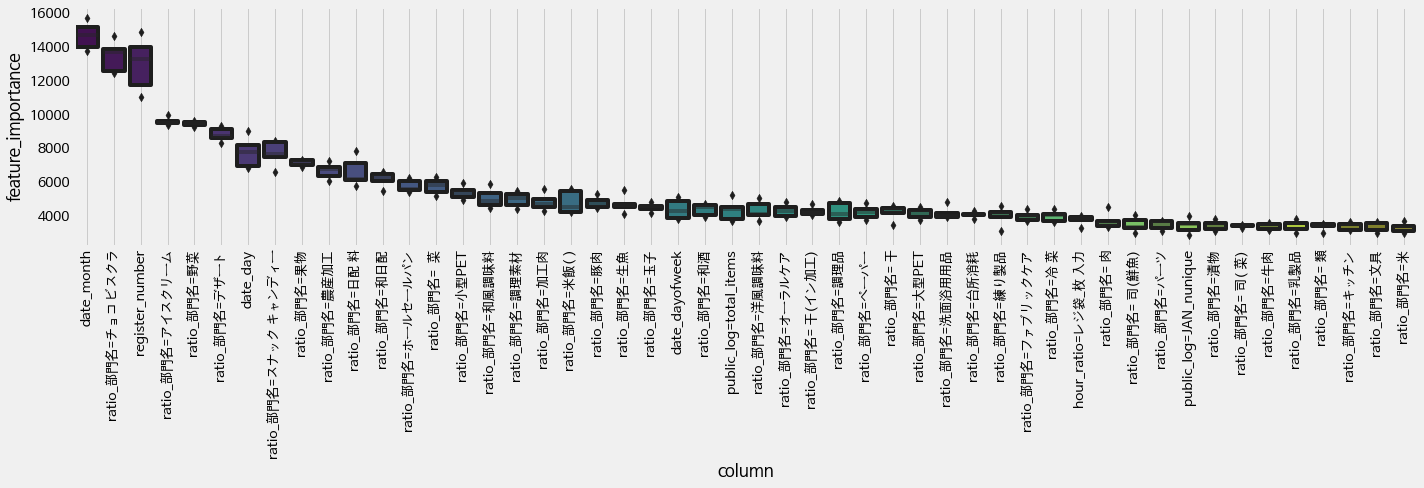

In [ ]:
fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
pred = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])
pred = np.mean(pred, axis=0)

<AxesSubplot:ylabel='Density'>

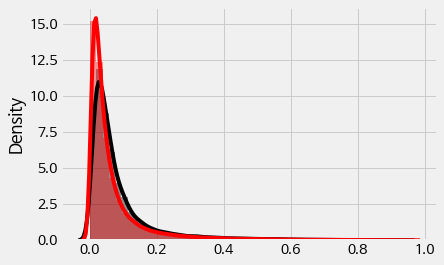

In [ ]:
,sns.distplot(pred, color='black', kde=True)
sns.distplot(oof_pred, color='red', kde=True)

In [ ]:
def create_predict(models:list, feat_df:pd.DataFrame) -> np.array:
    pred = np.array([model.predict_proba(feat_df.values)[:,1] for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def fit_and_predict(target_id):
    y = train_target_df[target_id].values
    oof_pred, models = fit_lgb(train_feat_df.values, y, params=params)
    
    fig, ax = visualize_importance(models, train_feat_df)
    target_name = id2cat[target_id]
    ax.set_title(f'TARGET {target_name}')
    fig.savefig(os.path.join(OUTPUT_DIR, f'png/{target_name}_feature_importance.png'), 
                dpi=120, facecolor='w', edgecolor='w', bbox_inches='tight')
    
    pred = create_predict(models, feat_df=test_feat_df)
    return oof_pred, pred

NameError: name 'pd' is not defined

  0%|                                                                                                                                                                            | 0/15 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.848673	valid_1's auc: 0.821138
[200]	training's auc: 0.879165	valid_1's auc: 0.842692
[300]	training's auc: 0.893929	valid_1's auc: 0.851219
[400]	training's auc: 0.904642	valid_1's auc: 0.856659
[500]	training's auc: 0.912508	valid_1's auc: 0.860378
[600]	training's auc: 0.919273	valid_1's auc: 0.86286
[700]	training's auc: 0.925025	valid_1's auc: 0.86446
[800]	training's auc: 0.930235	valid_1's auc: 0.865455
[900]	training's auc: 0.934933	valid_1's auc: 0.866149
[1000]	training's auc: 0.939293	valid_1's auc: 0.866796
[1100]	training's auc: 0.94326	valid_1's auc: 0.866893
[1200]	training's auc: 0.946892	valid_1's auc: 0.866963
Early stopping, best iteration is:
[1138]	training's auc: 0.944701	valid_1's auc: 0.867216
fit fold=1	74.001[s]


  7%|██████████▉                                                                                                                                                         | 1/15 [01:18<18:22, 78.73s/it]

train ビール系__RTD	78.721[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.838475	valid_1's auc: 0.810327
[200]	training's auc: 0.868922	valid_1's auc: 0.831633
[300]	training's auc: 0.884933	valid_1's auc: 0.84251
[400]	training's auc: 0.895218	valid_1's auc: 0.848762
[500]	training's auc: 0.902813	valid_1's auc: 0.852005
[600]	training's auc: 0.909405	valid_1's auc: 0.854233
[700]	training's auc: 0.915118	valid_1's auc: 0.856426
[800]	training's auc: 0.920729	valid_1's auc: 0.85791
[900]	training's auc: 0.925415	valid_1's auc: 0.858227
[1000]	training's auc: 0.930006	valid_1's auc: 0.858895
[1100]	training's auc: 0.93412	valid_1's auc: 0.859439
[1200]	training's auc: 0.937877	valid_1's auc: 0.859976
[1300]	training's auc: 0.941378	valid_1's auc: 0.860277
[1400]	training's auc: 0.944451	valid_1's auc: 0.86049
Early stopping, best iteration is:
[1343]	training's auc: 0.942803	valid_1's auc: 0.860536
fit fold=1	82.985[s]


 13%|█████████████████████▊                                                                                                                                              | 2/15 [02:46<18:13, 84.08s/it]

train ビール系__ビール系	87.826[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.92375	valid_1's auc: 0.827216
[200]	training's auc: 0.951838	valid_1's auc: 0.842855
[300]	training's auc: 0.965075	valid_1's auc: 0.849809
[400]	training's auc: 0.974033	valid_1's auc: 0.850711
[500]	training's auc: 0.980423	valid_1's auc: 0.851131
Early stopping, best iteration is:
[416]	training's auc: 0.975176	valid_1's auc: 0.851882
fit fold=1	31.433[s]


 20%|████████████████████████████████▊                                                                                                                                   | 3/15 [03:21<12:21, 61.78s/it]

train ビール系__ノンアルコール	35.238[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.748797	valid_1's auc: 0.727543
[200]	training's auc: 0.773127	valid_1's auc: 0.740997
[300]	training's auc: 0.78771	valid_1's auc: 0.747538
[400]	training's auc: 0.799463	valid_1's auc: 0.752576
[500]	training's auc: 0.808721	valid_1's auc: 0.755649
[600]	training's auc: 0.816534	valid_1's auc: 0.757595
[700]	training's auc: 0.823961	valid_1's auc: 0.759599
[800]	training's auc: 0.830615	valid_1's auc: 0.760784
[900]	training's auc: 0.836933	valid_1's auc: 0.761337
[1000]	training's auc: 0.842817	valid_1's auc: 0.762105
[1100]	training's auc: 0.848313	valid_1's auc: 0.762522
[1200]	training's auc: 0.853226	valid_1's auc: 0.762984
[1300]	training's auc: 0.858192	valid_1's auc: 0.76325
[1400]	training's auc: 0.862901	valid_1's auc: 0.763413
Early stopping, best iteration is:
[1368]	training's auc: 0.861437	valid_1's auc: 0.763645
fit fold=1	82.060[s]


 27%|███████████████████████████████████████████▋                                                                                                                        | 4/15 [04:48<13:07, 71.62s/it]

train スナック・キャンディー__スナック	86.704[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.75619	valid_1's auc: 0.729209
[200]	training's auc: 0.781887	valid_1's auc: 0.740879
[300]	training's auc: 0.798651	valid_1's auc: 0.746257
[400]	training's auc: 0.811553	valid_1's auc: 0.749277
[500]	training's auc: 0.821948	valid_1's auc: 0.750301
[600]	training's auc: 0.831603	valid_1's auc: 0.751305
[700]	training's auc: 0.839521	valid_1's auc: 0.751393
[800]	training's auc: 0.846921	valid_1's auc: 0.75153
[900]	training's auc: 0.854527	valid_1's auc: 0.751916
[1000]	training's auc: 0.861281	valid_1's auc: 0.752293
Early stopping, best iteration is:
[989]	training's auc: 0.860577	valid_1's auc: 0.752423
fit fold=1	64.525[s]


 33%|██████████████████████████████████████████████████████▋                                                                                                             | 5/15 [05:57<11:47, 70.77s/it]

train チョコ・ビスクラ__チョコレート	69.259[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.901586	valid_1's auc: 0.786699
[200]	training's auc: 0.937976	valid_1's auc: 0.793824
[300]	training's auc: 0.95563	valid_1's auc: 0.796629
[400]	training's auc: 0.96679	valid_1's auc: 0.798919
[500]	training's auc: 0.975639	valid_1's auc: 0.798783
Early stopping, best iteration is:
[465]	training's auc: 0.972948	valid_1's auc: 0.799484
fit fold=1	38.047[s]


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 6/15 [06:39<09:07, 60.89s/it]

train スナック・キャンディー__ガム	41.699[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.849469	valid_1's auc: 0.781336
[200]	training's auc: 0.883712	valid_1's auc: 0.795571
[300]	training's auc: 0.903241	valid_1's auc: 0.80146
[400]	training's auc: 0.916943	valid_1's auc: 0.804796
[500]	training's auc: 0.927828	valid_1's auc: 0.805909
[600]	training's auc: 0.937589	valid_1's auc: 0.806187
Early stopping, best iteration is:
[507]	training's auc: 0.928893	valid_1's auc: 0.806241
fit fold=1	42.846[s]


 47%|████████████████████████████████████████████████████████████████████████████▌                                                                                       | 7/15 [07:26<07:29, 56.24s/it]

train スナック・キャンディー__シリアル	46.659[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.831369	valid_1's auc: 0.799265
[200]	training's auc: 0.860435	valid_1's auc: 0.816652
[300]	training's auc: 0.877523	valid_1's auc: 0.824456
[400]	training's auc: 0.890084	valid_1's auc: 0.828277
[500]	training's auc: 0.899605	valid_1's auc: 0.830449
[600]	training's auc: 0.907107	valid_1's auc: 0.831568
[700]	training's auc: 0.914306	valid_1's auc: 0.832147
Early stopping, best iteration is:
[689]	training's auc: 0.913463	valid_1's auc: 0.83232
fit fold=1	54.141[s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 8/15 [08:24<06:38, 56.93s/it]

train アイスクリーム__ノベルティー	58.427[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.777942	valid_1's auc: 0.738267
[200]	training's auc: 0.809729	valid_1's auc: 0.751664
[300]	training's auc: 0.829446	valid_1's auc: 0.758442
[400]	training's auc: 0.844282	valid_1's auc: 0.760987
[500]	training's auc: 0.857304	valid_1's auc: 0.763706
[600]	training's auc: 0.86791	valid_1's auc: 0.764605
[700]	training's auc: 0.876257	valid_1's auc: 0.765147
Early stopping, best iteration is:
[690]	training's auc: 0.875416	valid_1's auc: 0.76538
fit fold=1	49.552[s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 9/15 [09:18<05:35, 55.91s/it]

train 和菓子__米菓	53.640[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.925086	valid_1's auc: 0.874224
[200]	training's auc: 0.951829	valid_1's auc: 0.888525
[300]	training's auc: 0.963179	valid_1's auc: 0.893541
[400]	training's auc: 0.971082	valid_1's auc: 0.895547
[500]	training's auc: 0.976381	valid_1's auc: 0.89691
[600]	training's auc: 0.980475	valid_1's auc: 0.89743
[700]	training's auc: 0.983459	valid_1's auc: 0.897571
Early stopping, best iteration is:
[607]	training's auc: 0.980668	valid_1's auc: 0.897707
fit fold=1	45.113[s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 10/15 [10:07<04:29, 53.81s/it]

train 水・炭酸水__大型PET（炭酸水）	49.124[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.871382	valid_1's auc: 0.829502
[200]	training's auc: 0.905816	valid_1's auc: 0.844283
[300]	training's auc: 0.924189	valid_1's auc: 0.850333
[400]	training's auc: 0.936599	valid_1's auc: 0.853815
[500]	training's auc: 0.945533	valid_1's auc: 0.855089
[600]	training's auc: 0.952524	valid_1's auc: 0.855553
Early stopping, best iteration is:
[581]	training's auc: 0.951432	valid_1's auc: 0.855961
fit fold=1	40.442[s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 11/15 [10:51<03:23, 50.92s/it]

train 水・炭酸水__小型PET（炭酸水）	44.347[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.96457	valid_1's auc: 0.920173
[200]	training's auc: 0.979795	valid_1's auc: 0.926869
[300]	training's auc: 0.9872	valid_1's auc: 0.928619
Early stopping, best iteration is:
[288]	training's auc: 0.98642	valid_1's auc: 0.929106
fit fold=1	23.533[s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 12/15 [11:18<02:11, 43.71s/it]

train 缶飲料__コーヒー（缶）	27.224[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.900525	valid_1's auc: 0.848092
[200]	training's auc: 0.93103	valid_1's auc: 0.856832
[300]	training's auc: 0.946649	valid_1's auc: 0.860425
[400]	training's auc: 0.957957	valid_1's auc: 0.862082
[500]	training's auc: 0.965813	valid_1's auc: 0.862446
Early stopping, best iteration is:
[468]	training's auc: 0.963657	valid_1's auc: 0.862654
fit fold=1	35.955[s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 13/15 [11:58<01:25, 42.55s/it]

train 小型PET__コーヒー（小型PET）	39.894[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.860017	valid_1's auc: 0.824448
[200]	training's auc: 0.892275	valid_1's auc: 0.841639
[300]	training's auc: 0.910954	valid_1's auc: 0.849952
[400]	training's auc: 0.922386	valid_1's auc: 0.853563
[500]	training's auc: 0.930863	valid_1's auc: 0.85539
[600]	training's auc: 0.938596	valid_1's auc: 0.857256
[700]	training's auc: 0.945455	valid_1's auc: 0.858674
[800]	training's auc: 0.950944	valid_1's auc: 0.859254
[900]	training's auc: 0.955955	valid_1's auc: 0.85893
Early stopping, best iteration is:
[808]	training's auc: 0.951309	valid_1's auc: 0.859484
fit fold=1	57.424[s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 14/15 [13:00<00:48, 48.33s/it]

train 大型PET__無糖茶（大型PET）	61.688[s]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.757339	valid_1's auc: 0.710345
[200]	training's auc: 0.789216	valid_1's auc: 0.72685
[300]	training's auc: 0.807569	valid_1's auc: 0.73306
[400]	training's auc: 0.822808	valid_1's auc: 0.738894
[500]	training's auc: 0.834783	valid_1's auc: 0.741338
[600]	training's auc: 0.845284	valid_1's auc: 0.742874
[700]	training's auc: 0.854269	valid_1's auc: 0.743022
Early stopping, best iteration is:
[640]	training's auc: 0.848943	valid_1's auc: 0.743445
fit fold=1	47.836[s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [13:52<00:00, 55.50s/it]

train 麺類__カップ麺	51.989[s]
Wall time: 13min 52s


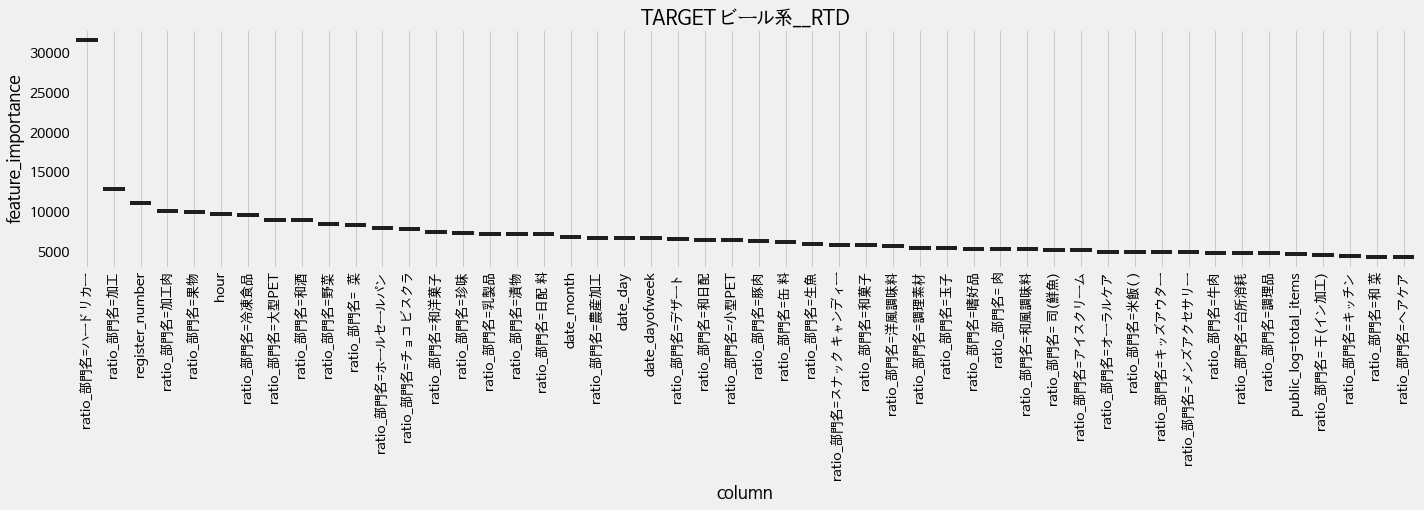

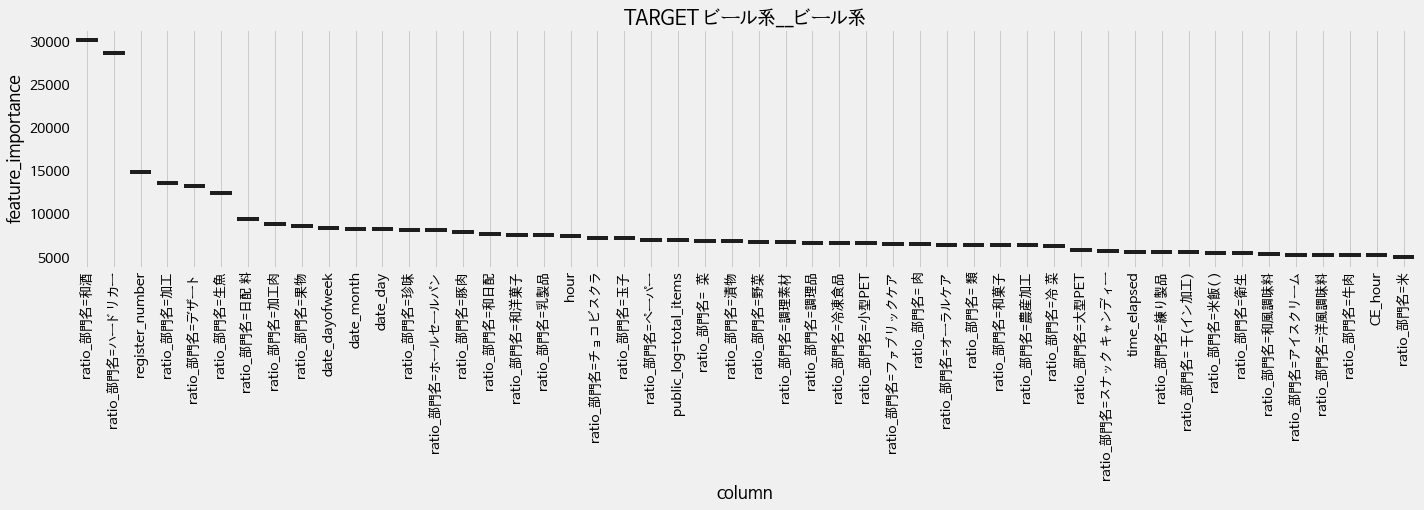

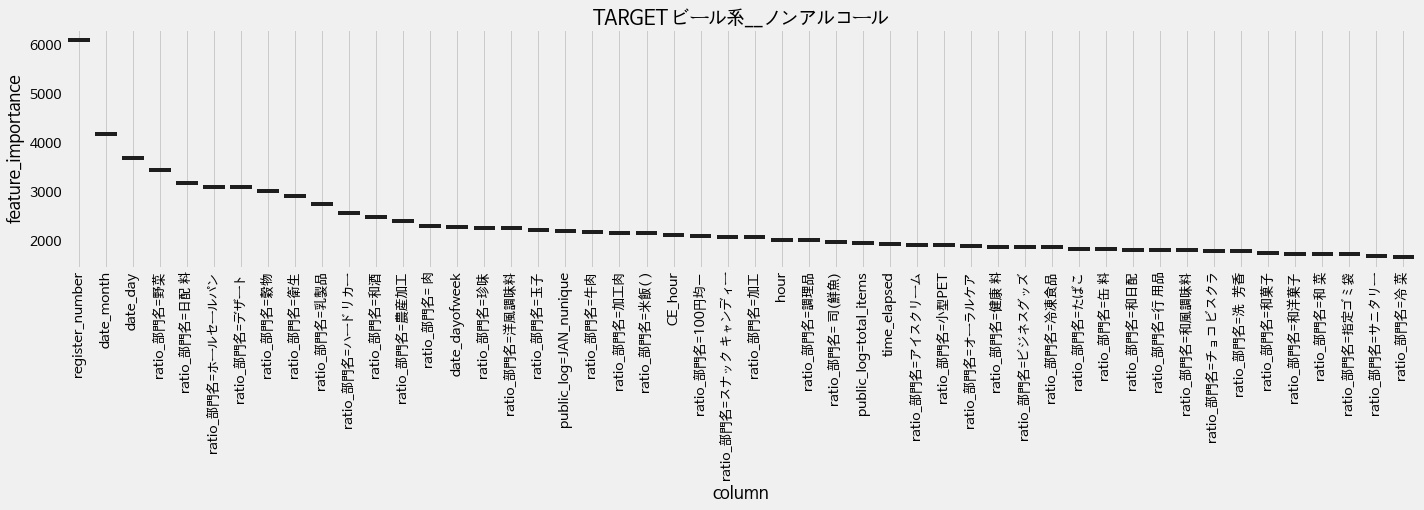

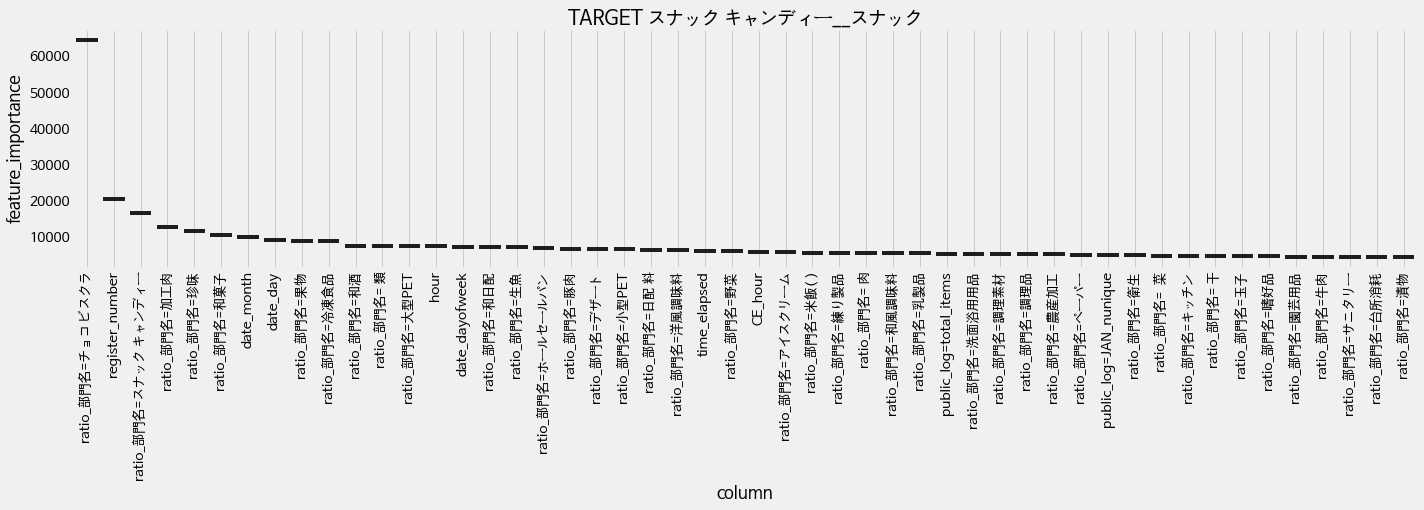

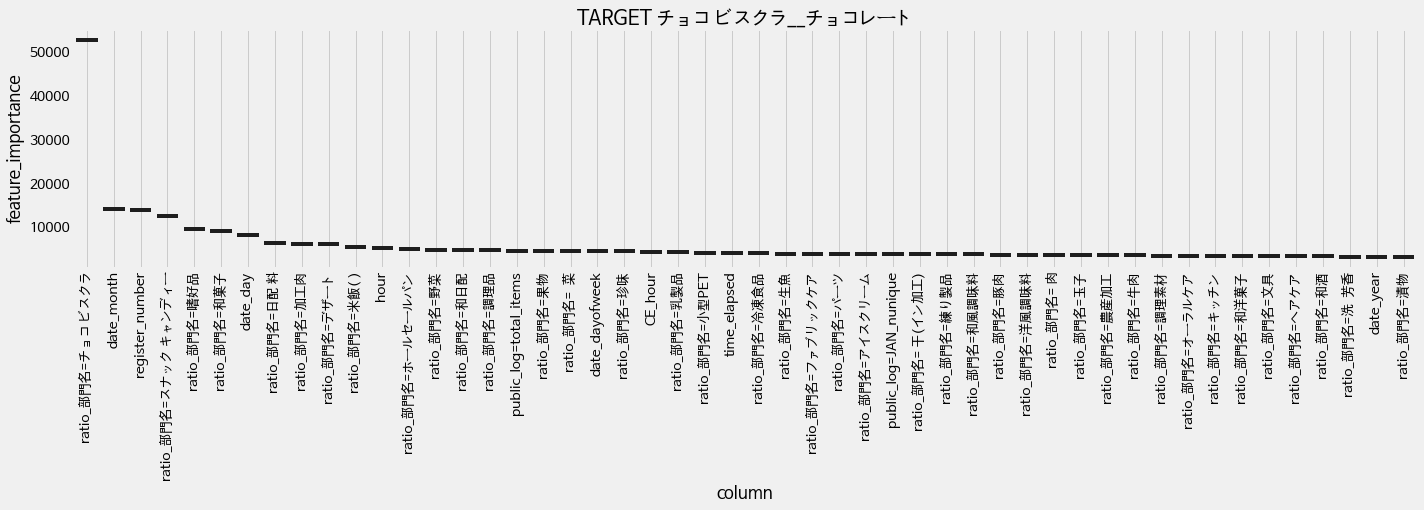

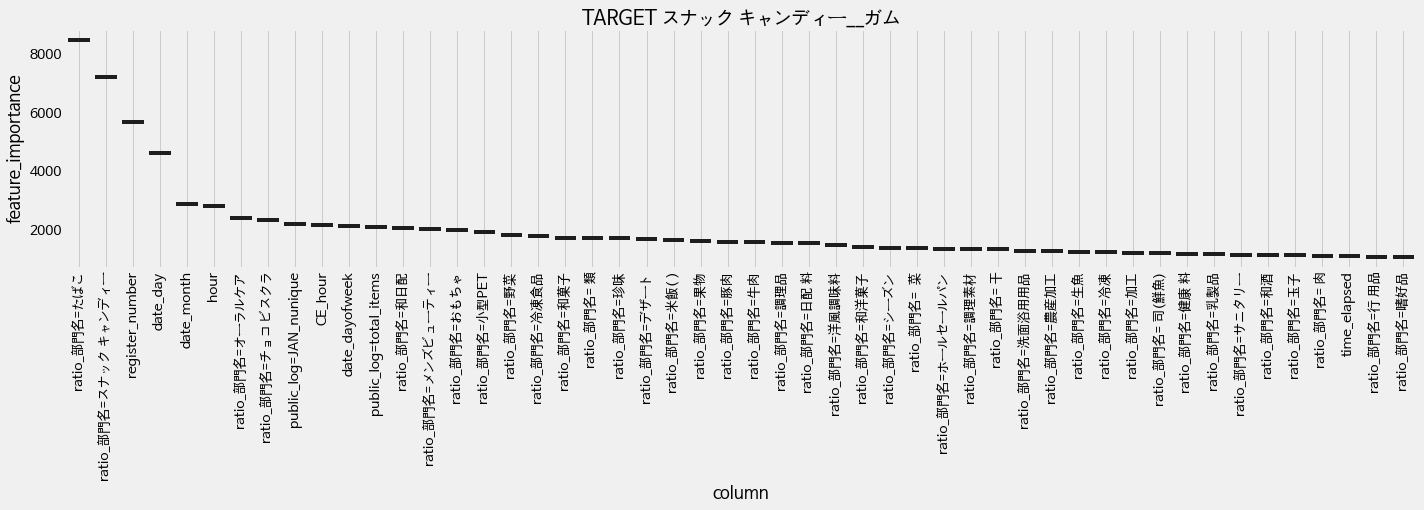

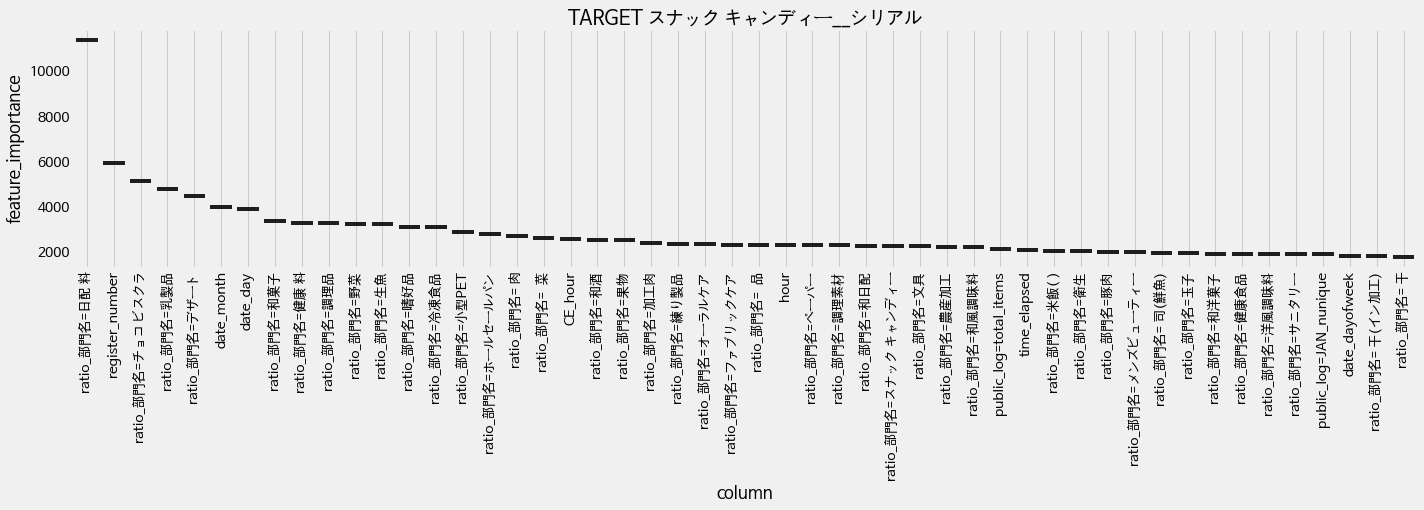

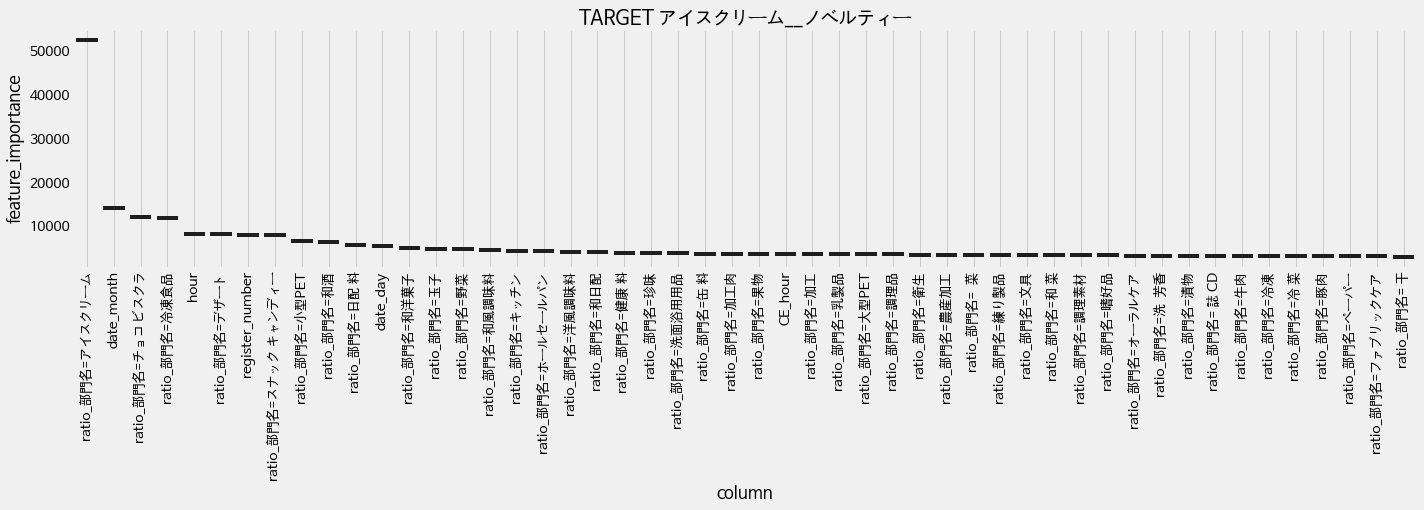

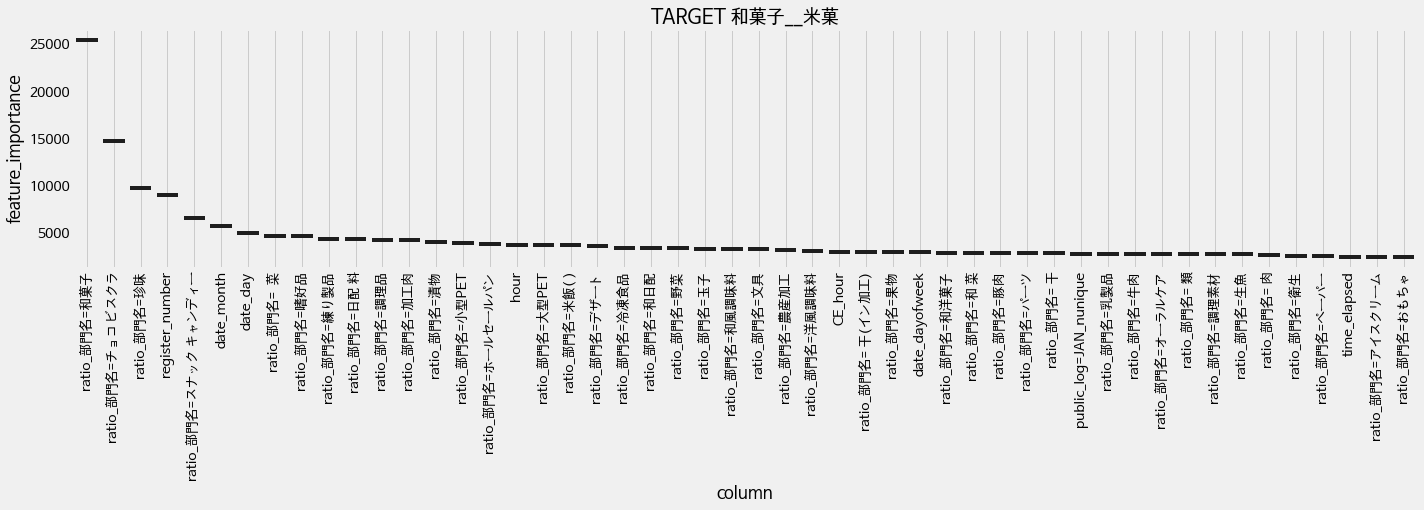

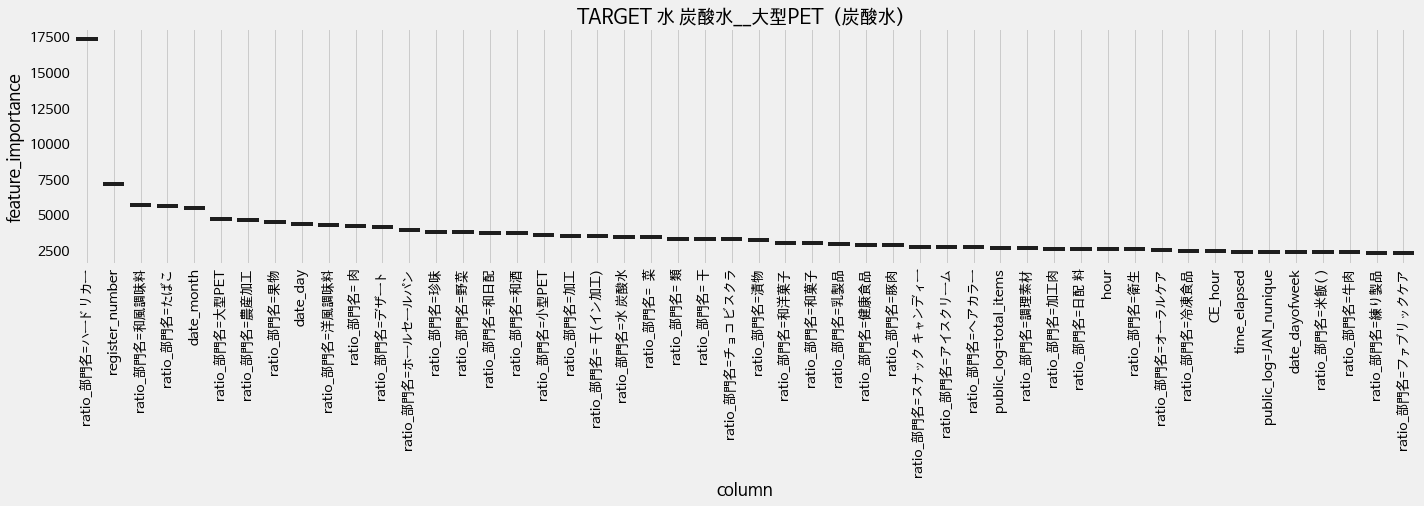

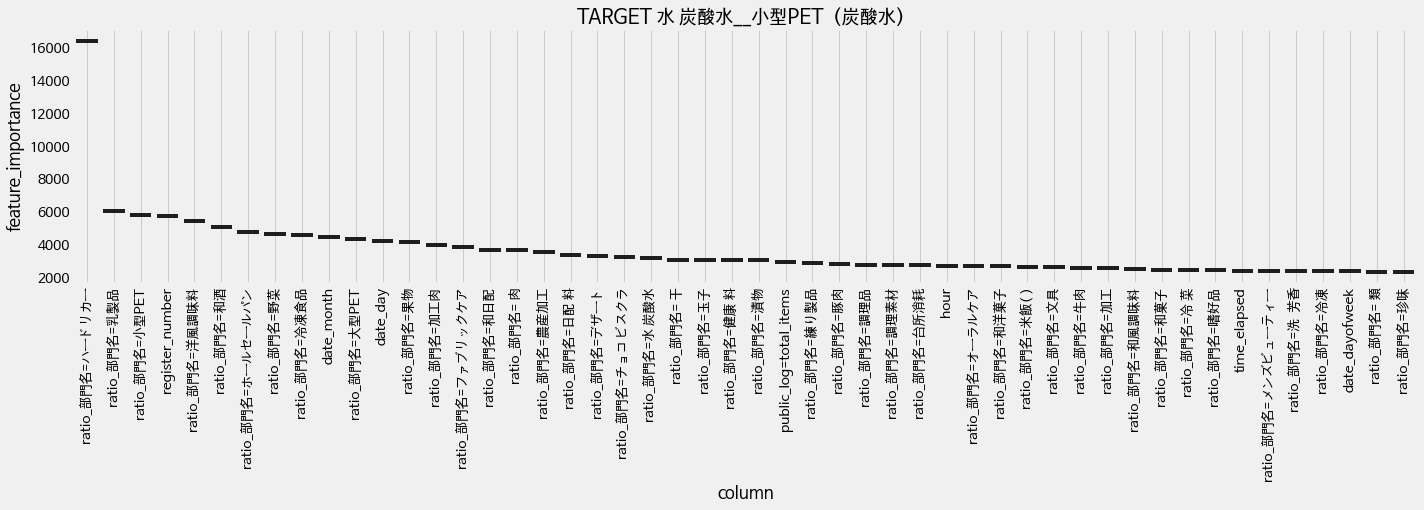

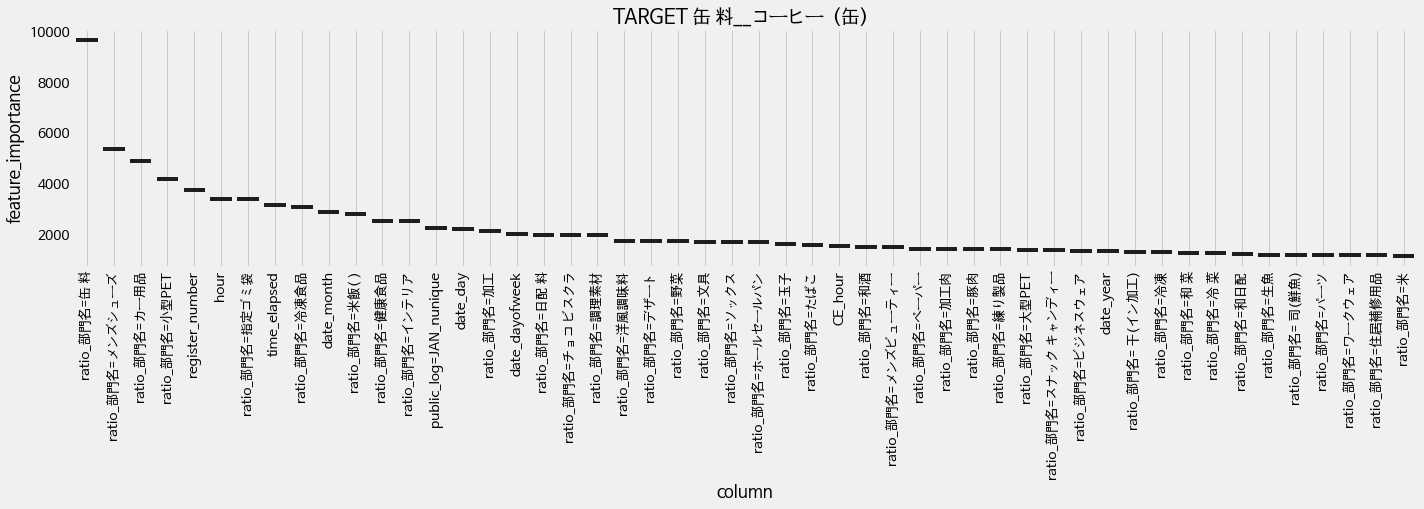

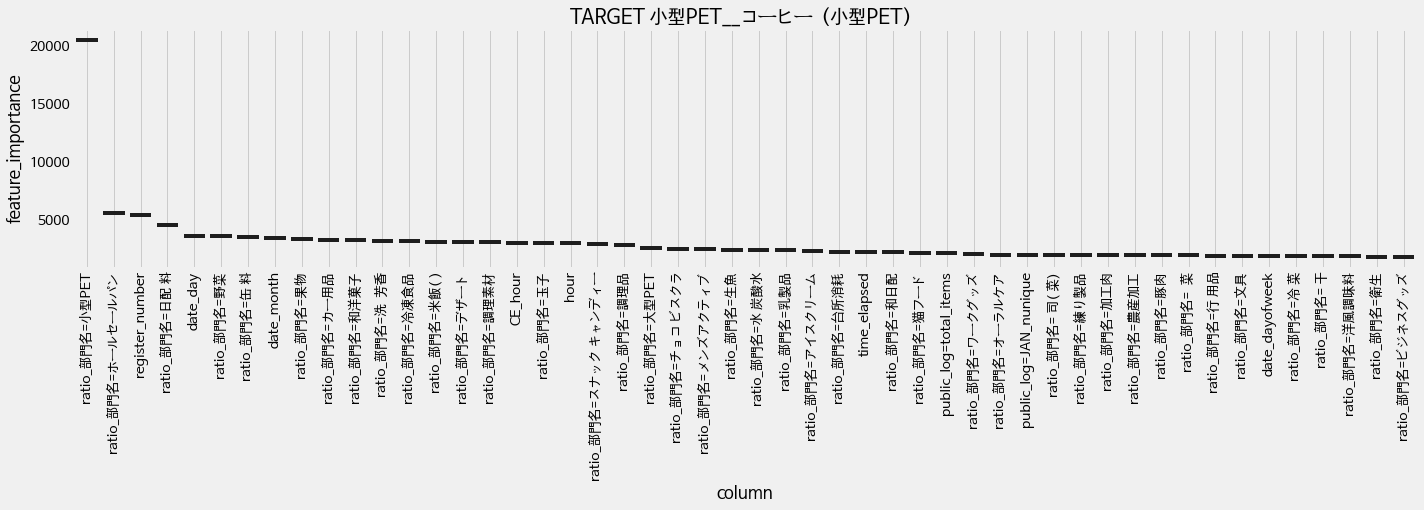

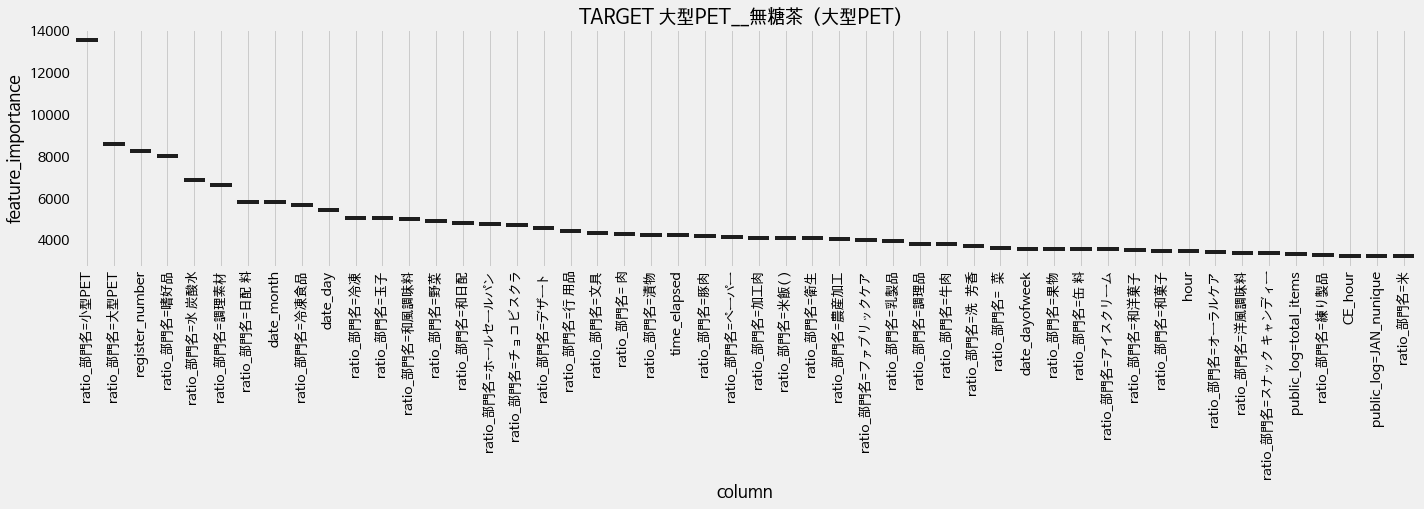

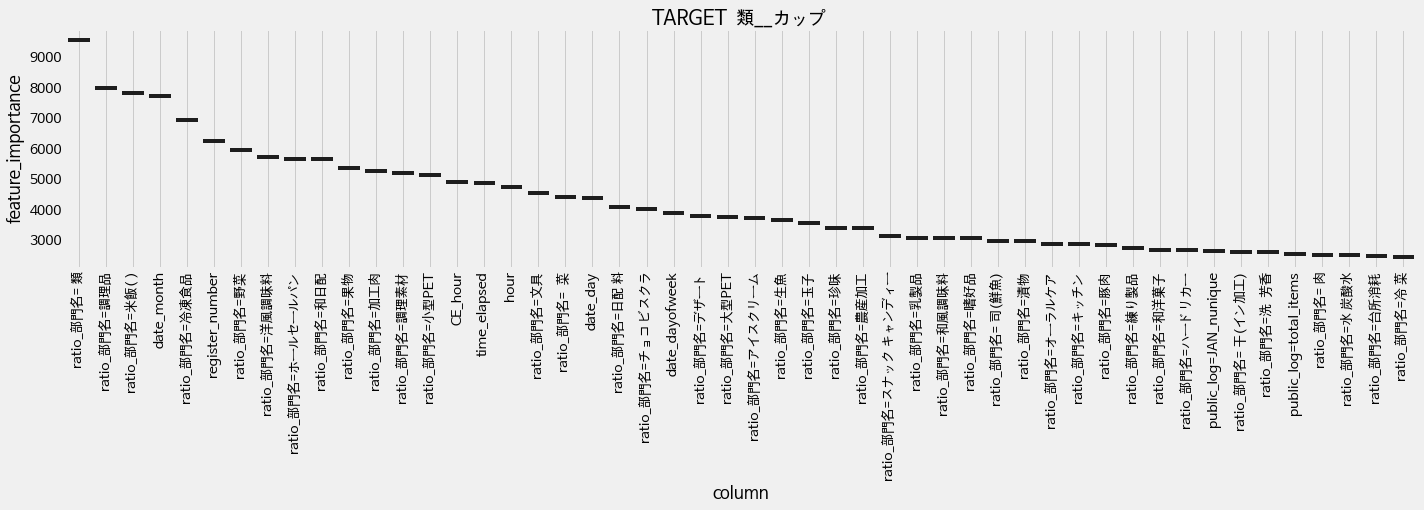

In [ ]:
%%time

oof_pred_df, pred_df = pd.DataFrame(), pd.DataFrame()

for target_col_id in tqdm(TARGET_IDS, total=15):
    with timer(prefix=f'train {id2cat[target_col_id]}\t'):
        oof_pred, pred = fit_and_predict(target_col_id)
    oof_pred_df[target_col_id] = oof_pred
    pred_df[target_col_id] = pred

In [ ]:
fix, ax =plt.subplots(figsize=(8, 8))

for c in tqdm(TARGET_IDS, total=15):
    fpr, tpr, _ = roc_curve(train_target_df[c], oof_pred_df[c])
    ax.plot(fpr, tpr, label=id2cat[c])
ax.legend()
ax.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='gray')

In [ ]:
roc_auc_score(train_target_df, oof_pred_df, average='macro')

ValueError: Found input variables with inconsistent numbers of samples: [473416, 74031]

In [ ]:
pred_df.to_csv(os.path.join(OUTPUT_DIR, 'csv/submission.csv'), index=False)